![skyline](Images/skyline.jpg)

# King County Housing Sale Prices

In this project I'm going to analyze the King's County housing data set listing various data points for property sales in the King's County area of Washington (centered around Seattle). I will be using Linear Regression to identify the most influential variables controlling sale price. For the purposes of this exercise, I will be working from the position as a consultant to a hypothetical housing developer in the Seattle area. I will be using the OSEMN (Obtain, Scrub, Explore, Model, Interpret) Data Science process in this project.

## The Business Problem

The King's County data shows various metrics for houses that sold to homebuyers in 2014 and 2015. As a consultant, my task is to identify the greatest factors that increase the sale price of homes so the developer can maximize sale price of their new housing construction projects. Such factors might include: where to build the new homes, how much land they should have, the overall quality of the construction, the size of the home, etc. To begin I'm going to import the relevant packages for my analysis as well as the dataset as the DataFrame 'df'. For the 'Obtain' part of the OSEMN process, the data has been provided, so we can continue to the 'Scrub' step.

In [1]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
from statsmodels.formula.api import ols
import matplotlib.pyplot as plt
import seaborn as sns
import utils as ut
import scipy.stats as stats
%matplotlib inline

from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import folium
from folium.plugins import HeatMap

df = pd.read_csv('data/kc_house_data.csv')
df.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,10/13/2014,221900.0,3,1.00,1180,5650,1.0,NaN,0.0,...,7,1180,0.0,1955,0.0,98178,47.5112,-122.257,1340,5650
1,6414100192,12/9/2014,538000.0,3,2.25,2570,7242,2.0,0.0,0.0,...,7,2170,400.0,1951,1991.0,98125,47.7210,-122.319,1690,7639
2,5631500400,2/25/2015,180000.0,2,1.00,770,10000,1.0,0.0,0.0,...,6,770,0.0,1933,NaN,98028,47.7379,-122.233,2720,8062
3,2487200875,12/9/2014,604000.0,4,3.00,1960,5000,1.0,0.0,0.0,...,7,1050,910.0,1965,0.0,98136,47.5208,-122.393,1360,5000
4,1954400510,2/18/2015,510000.0,3,2.00,1680,8080,1.0,0.0,0.0,...,8,1680,0.0,1987,0.0,98074,47.6168,-122.045,1800,7503


Here is a more detailed breakdown of the data in each column as well as the number of null values per variable.

In [2]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21597 entries, 0 to 21596
Data columns (total 21 columns):
id               21597 non-null int64
date             21597 non-null object
price            21597 non-null float64
bedrooms         21597 non-null int64
bathrooms        21597 non-null float64
sqft_living      21597 non-null int64
sqft_lot         21597 non-null int64
floors           21597 non-null float64
waterfront       19221 non-null float64
view             21534 non-null float64
condition        21597 non-null int64
grade            21597 non-null int64
sqft_above       21597 non-null int64
sqft_basement    21597 non-null object
yr_built         21597 non-null int64
yr_renovated     17755 non-null float64
zipcode          21597 non-null int64
lat              21597 non-null float64
long             21597 non-null float64
sqft_living15    21597 non-null int64
sqft_lot15       21597 non-null int64
dtypes: float64(8), int64(11), object(2)
memory usage: 3.5+ MB


## Functions

All functions I will be using for this project can be found in the utils.py file in this repository. Please feel free to peruse them at your leisure. The most important function for this project is the sk_linear_regression function that I will be using for the majority of my linear regressions. I will be using a blend of sci-kit learn regression models and OLS from StatsModels. I will also be using a default 25% test/train split for my data. That split is made in both the sk_linear_regression function and the sm_linear_regression function, and both use the same random seed to ensure the data is exactly the same for both models.

## The Data

After loading in the data set we see the raw data contains the following columns:

- **Id** - The index of house in the data set
- **Date** - The date of the house's sale
- **Price** - The final price of the home at the time of sale
- **Bedrooms** - The number of bedrooms in the house
- **Bathrooms** - The number of bathrooms in the house (a decimal to account for toilet-only bathrooms etc.)
- **sqft_living** - The square footage of the living area
- **sqft_lot** - The size of building's plot of land
- **Floors** - The number of floors in the house (half counts for an attic)
- **Waterfront** - A binary value indicating if the house has a waterfront view.
- **View** - How many times the home was viewed before it sold
- **Condition** - The overall condition grade of the home
- **Grade** - The overall quality grade of the home
- **sqft_above** - The square footage of the home above ground
- **sqft_basement** - The square footage of the basement
- **yr_built** - The year the home was built
- **yr_renovated** - The year the home was renovated
- **zipcode** - The zipcode of the home
- **lat** - The house's latitude
- **long** - The house's longitude
- **sqft_living15** - The average square footage of the interiors of the nearest 15 neighbors
- **sqft_lot15** - The average square footage of the lots of the nearest 15 neighbors.

I cleaned the data and dropped any pieces of information that are either incompatible with a linear model or not applicable to the business problem.

1. **Waterfront** - filled the NaNs with zeroes because it is more likely to not have waterfront views if it doesn't have a value there. This can be verified by looking at the house's coordinates on folium.
2. **Views** - removed this column because the number of times a house is viewed is not a controllable variable
3. **Date** - removed this column because datetime values are incompatible with linear regression and there are so many factors that affect sale date that it cannot be seen as a controllable variable.
4. **Year Renovated/Year Built** - eventually, I turned these column into a boolean value if the house was renovated in the last 10 years. The interaction between older homes and newer construction is an interesting comparison, especially if the developer will either have to build new homes or remodel older homes for resale. This will be addressed in Model 3 when I deal with categoricals. For the first few models they will remain as is.
5. **Sqft_Basement** - Replaced the '?' values with 0s, as an unknown basement size is most likely going to be that the building doesn't have a basement. Also, changed the data type from object to float64 to make it compatible with the linear model.
6. **Bedrooms** - There was one outlier that had a value of 33, though the rest of the square footage data gave the impression that this was a typo. I changed the value to '3' but the rest of the data was fine.
7. **Grade** - This value is normally distributed, which is very good, but has some strange outliers (12 and 13) but since the Grade is an ordinal category, then we don't have to assume a clean 1-10 value system.
8. **Yr_Built** - Kept this value as a continuous variable but will manipulate it for some of the models. This value affects the boolean 'Recent_Construction' that returns true if the house was built or renovated in the last 10 years.
9. **Latitude and Longitude** - there are some outliers to the east, but the majority of the data is clustered around the city center. Later models will cluster these coordinates into neighborhoods for further analysis.
    
Below you can see my code for some of my data cleaning. This is the 'Scrub' part of the OSEMN process and the visualizations of the locations of the data and its outliers are part of the 'Explore' stage. 

In [3]:
# Data Cleaning
df.waterfront.fillna(0,inplace=True)
df.drop(columns=['view','date'])
df.yr_renovated.fillna(0,inplace=True)
df.sqft_basement.replace('?',0,inplace=True)
df.sqft_basement = df.sqft_basement.astype('float64')
df.bedrooms.replace(33, 3,inplace=True)

In [4]:
# A map of the housing data in question and where it is clustered around the Greater Seattle Area. 
# I centered it on the mean latitude and longitude of the data

import folium
from folium.plugins import HeatMap

lat = df.lat.mean()
long = df.long.mean()

map_1 = folium.Map(location=[lat, long], zoom_start=9)
heat_data = [[row['lat'],row['long']] for index, row in df.iterrows()]

HeatMap(heat_data, min_opacity=0.1).add_to(map_1)
map_1


### Baseline 'Bad' Model

With our data scrubbed and explored, we can begin to model. To begin, we will establish a baseline with a model using both SK Learn and StatsModels. The data has not been processed other than the basic cleaning above. I divided my data into continuous, categorical and outcome data, but for the purpose of this model, categorical and continuous variables will both be treated as continuous. I will manipulate this as I iterate through my models, but this is the basic setup to begin. My outcome, price, is the success metric.

In [5]:
continuous = ['sqft_living','sqft_lot','sqft_above','yr_built','yr_renovated','lat','long','sqft_living15','sqft_lot15','sqft_basement']
categorical = ['bedrooms', 'bathrooms','floors','waterfront','condition','grade','zipcode']
removed = ['views','date','id']
outcome = ['price']

I will use my sk_linear_regression function to produce our first model. It will also create a scatter plot of the model's residuals as well as a histogram of the test and train residuals for comparison.

Training Scores:
R2: 0.6971857664620761
Root Mean Squared Error: 198517.72757005875
Mean Absolute Error: 127137.95303547624
---
Testing Scores:
R2: 0.6770320248473616
Root Mean Squared Error: 219645.4675533081
Mean Absolute Error: 129729.80964818248


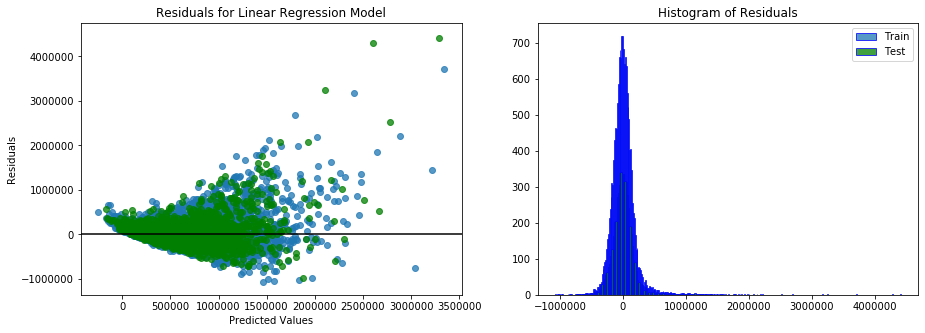

LinearRegression()

In [6]:
ut.sk_linear_regression(df, continuous+categorical, outcome)

### Analysis
As we can see the R2 score is 0.697 for the training data and 0.677 for the testing data. This means this model can account for about 68% of the testing data's variance. In practice, this means that our outcome data has an error of around $130,000, which isn't particularly helpful.

In addition to that, the test data has a worse fit than the training data, meaning that the model is slightly over-fit. We can do a lot better. From the residuals plots, we can see the data has strong heteroscedasticity, due to the 'funnel' shape of the residuals scatter plot. In addition, the histogram has strong kurtosis. For more detail, I've provided the same model in Stats Models below:

In [7]:
model = ut.sm_linear_regression(df, continuous+categorical, outcome)
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.697
Model:                            OLS   Adj. R-squared:                  0.697
Method:                 Least Squares   F-statistic:                     2191.
Date:                Sat, 30 Jan 2021   Prob (F-statistic):               0.00
Time:                        16:25:21   Log-Likelihood:            -2.2056e+05
No. Observations:               16197   AIC:                         4.412e+05
Df Residuals:                   16179   BIC:                         4.413e+05
Df Model:                          17                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const         -1.833e+06   3.34e+06     -0.548      0.584   -8.39e+06    4.72e+06
sqft_living     123.9794     20.357      6.090      0.000      84.077     163.882
sqft_lot          0.1780      0.054      3.318      0.001       0.073       0.283
sqft_above       49.1335     20.318      2.418      0.016       9.309      88.958
yr_built      -2765.8695     81.354    -33.998      0.000   -2925.332   -2606.407
yr_renovated     28.0451      4.513      6.215      0.000      19.200      36.890
lat            5.763e+05   1.22e+04     47.257      0.000    5.52e+05       6e+05
long          -2.264e+05   1.51e+04    -14.961      0.000   -2.56e+05   -1.97e+05
sqft_living15    38.6554      3.888      9.942      0.000      31.034      46.277
sqft_lot15       -0.4425      0.086     -5.160      0.000      -0.611      -0.274
sqft_basement    42.4458     20.136      2.108      0.035       2.978      81.914
bedrooms      -4.043e+04   2246.748    -17.993      0.000   -4.48e+04    -3.6e+04
bathrooms      3.701e+04   3727.920      9.927      0.000    2.97e+04    4.43e+04
floors         1.445e+04   4120.397      3.506      0.000    6369.866    2.25e+04
waterfront     7.808e+05   1.95e+04     40.097      0.000    7.43e+05    8.19e+05
condition      2.568e+04   2669.511      9.619      0.000    2.04e+04    3.09e+04
grade          1.031e+05   2457.378     41.971      0.000    9.83e+04    1.08e+05
zipcode        -494.9061     37.677    -13.136      0.000    -568.757    -421.055
==============================================================================
Omnibus:                    11588.606   Durbin-Watson:                   2.020
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           560829.966
Skew:                           2.910   Prob(JB):                         0.00
Kurtosis:                      31.234   Cond. No.                     2.16e+08
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.16e+08. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

### Baseline Analysis and Plan of Action

From this basic model, we can see that several variables might not be significant (the added constant has a 58% chance that it's zero). Meanwhile, we can see how poorly fit the model is based on its high Kurtosis and Skew scores. Not only that but the summary also alerts us to the possibility of strong multicollinearity in the model.

From the R2 scores, we can see there is a lot of work to be done, but in order to identify what transformations would be useful, we're going to begin by analyzing the model's residuals.  We can see this below in the residual QQ plot how non-normal the residuals are. This hints that we have outliers and possibly heteroscedasticity, both of which could severely skew our results.

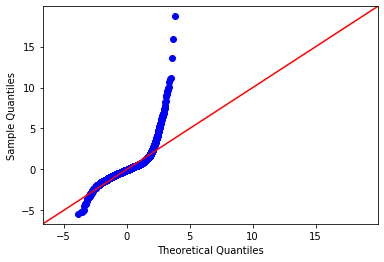

In [8]:
#QQ PLot for Residuals on the baseline model
ut.qqplot(model)

In order to determine the next steps of the process, we need to look at how each variable performed within the first model. Below you can see the regression plot showing residual analysis for the sqft_living variable. I completed the same process for all continuous variables:

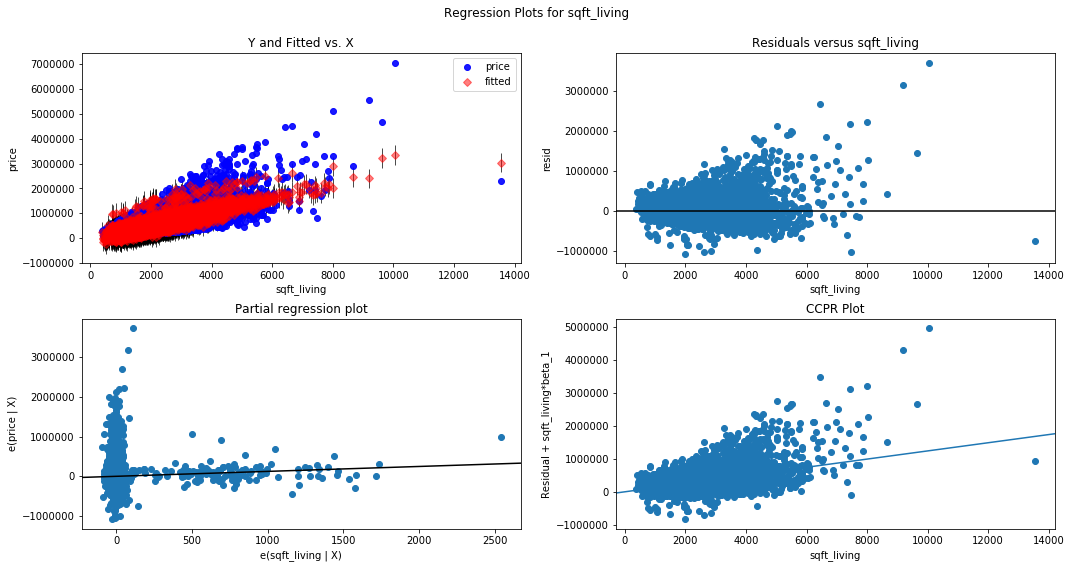

In [9]:
ut.regress_plots(['sqft_living'],model)

As we can see, there is a strong case that the sqft_living variable is heteroscedastic and will throw off our model considerably. One of the possible causes is that, as housing price increases, it follows a logarithmic pattern. The first possible remedy is the log transform some of the variables to see if the outliers reduce their influence. Below you can see the histogram of the sqft_living variable and the price outcome variable next to the log transformation of that data:

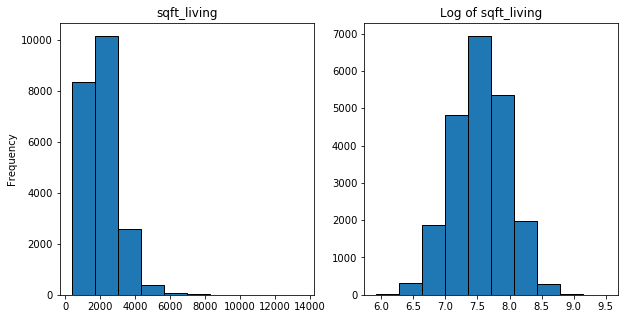

In [10]:
ut.log_transform(df,'sqft_living')

And if we apply the same transformation to the Price column, we can see that it takes a heavily skewed dataset and gives it a greater degree of normalcy.

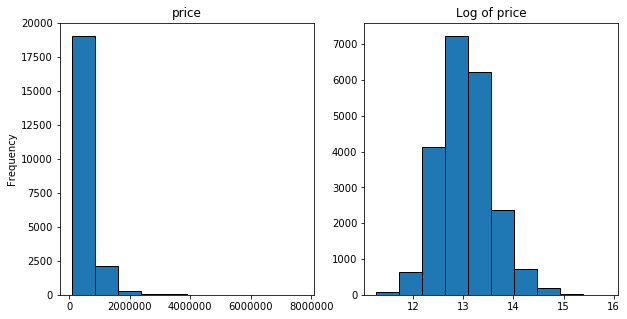

In [11]:
ut.log_transform(df, 'price')

## Model 2: Log Transformations

The histograms above show us that log transforming the variable sqft_living could be greatly impactful to the accuracy of our model. Not only does it make the data far more normal in shape, but also handles outliers effectively. We will continue this process with the other continuous variables to see if there are any other log transformations that would be helpful.

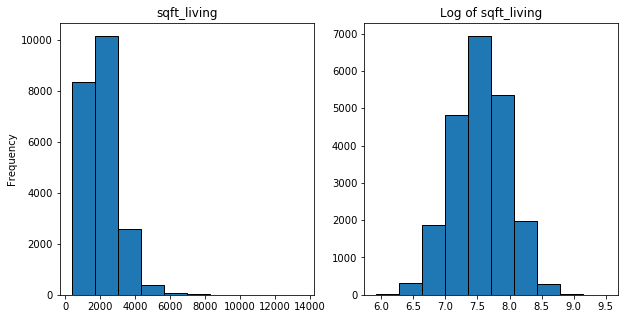

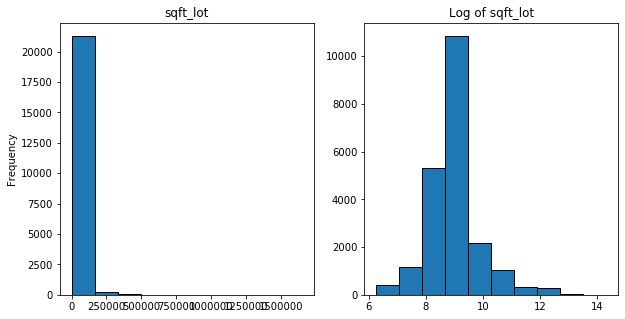

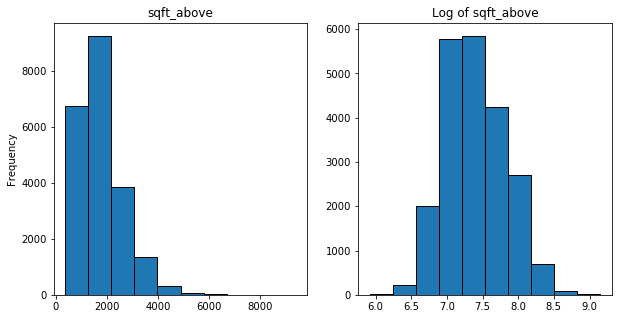

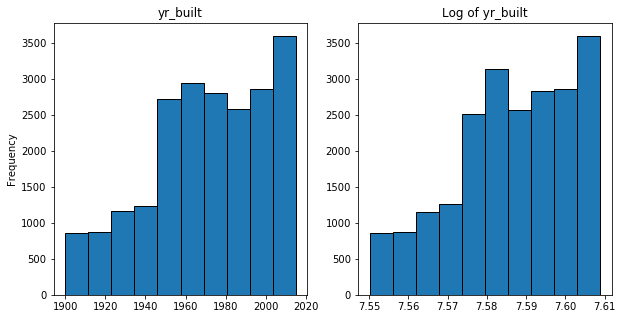

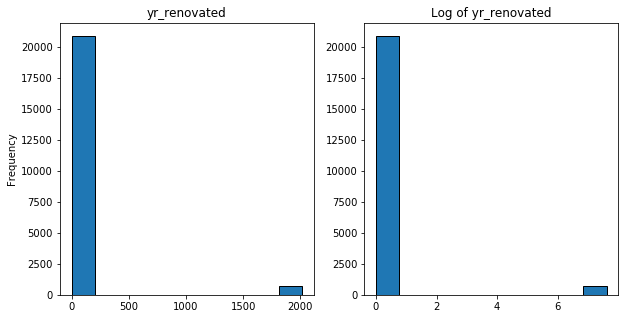

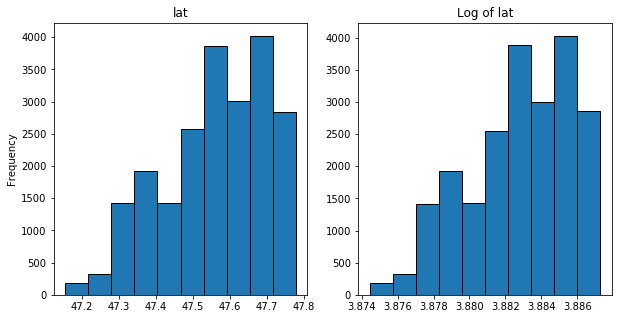

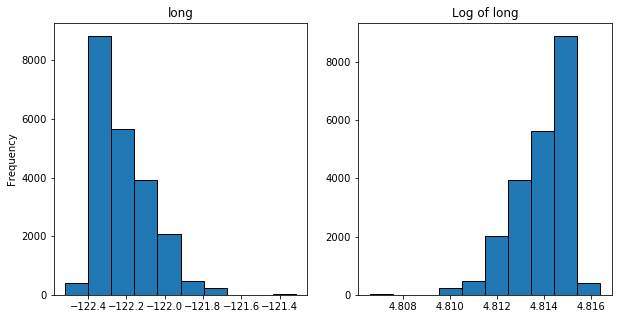

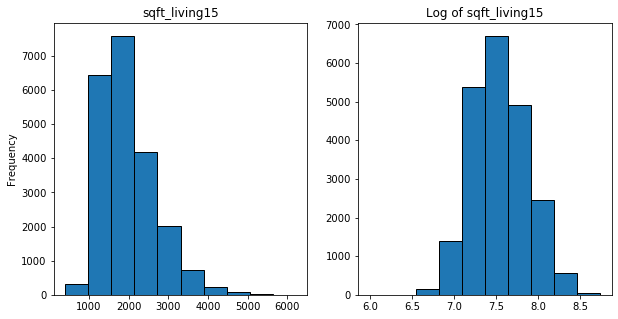

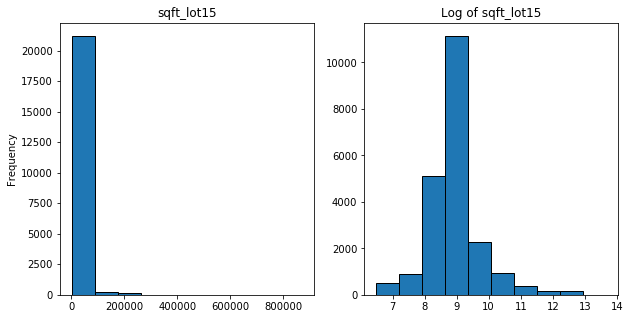

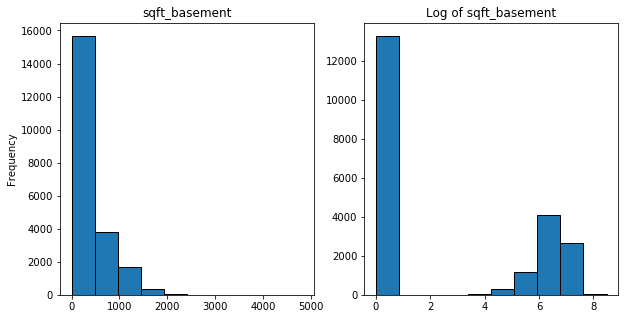

In [12]:
for column in continuous:
    ut.log_transform(df, column)

As we can can see from the transformations that the following variables became far more normal (albeit with a good deal of kurtosis). From this, we can see that we might increase the model's accuracy by transforming the following columns:

    - Sqft_living
    - Sqft_lot
    - Sqft_above
    - Sqft_living15
    - Sqft_lot15
    - Price
    
If we apply these log transformations to our model we will see if that increases our accuracy. We will not transform 'Price' at the moment, but it will be transformed in the function sk_linear_regression and then inverted in order to evaluate the Mean Absolute Error and Root Mean Squared Error scores.

In [13]:
log_cols = ['sqft_living','sqft_lot','sqft_above','sqft_living15','sqft_lot15']

logs = []

for x in log_cols:
    df[f'{x}_log'] = np.log(df[x])
    logs.append(f'{x}_log')
    
df_log = df.drop(columns=log_cols)

In [14]:
continuous = ['yr_built','yr_renovated','lat','long','sqft_basement']
outcome = 'price'

Training Scores:
R2: 0.7658382938869304
Root Mean Squared Error: 181278.43936269026
Mean Absolute Error: 109609.71324391567
---
Testing Scores:
R2: 0.7675951054578692
Root Mean Squared Error: 194931.9610205289
Mean Absolute Error: 110764.94830972413


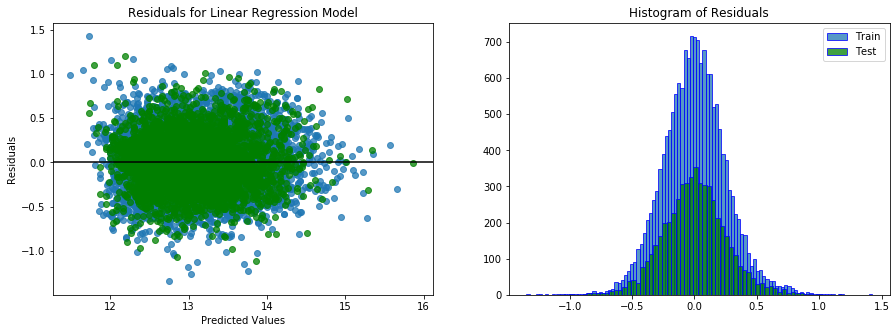

LinearRegression()

In [15]:
ut.sk_linear_regression(df_log, continuous+logs+categorical, outcome, log=True)

In this version of the model, we can now account for 76.8% of the data's variance. This time, instead of the model being overfit, we can tell it's slightly underfit because the testing scores have a better R2 than the training scores. We have reduced the Mean Absolute Error to $111,000. While that won't be useful in accurately determining the price of a proprerty, it's a solid step in the correct direction. The residuals look far more normal than they did before, so the issue of heteroscedasticity seems to have been solved for the moment. If we look at the StatsModel version we can see a little more detail:

In [16]:
model = ut.sm_linear_regression(df, continuous+logs+categorical, outcome, log=True)
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.766
Model:                            OLS   Adj. R-squared:                  0.766
Method:                 Least Squares   F-statistic:                     3113.
Date:                Sat, 30 Jan 2021   Prob (F-statistic):               0.00
Time:                        16:25:27   Log-Likelihood:                -788.84
No. Observations:               16197   AIC:                             1614.
Df Residuals:                   16179   BIC:                             1752.
Df Model:                          17                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const               -15.1579      4.385     -3.456      0.001     -23.754      -6.562
yr_built             -0.0040      0.000    -38.191      0.000      -0.004      -0.004
yr_renovated       3.953e-05   5.78e-06      6.839      0.000    2.82e-05    5.09e-05
lat                   1.3412      0.016     85.412      0.000       1.310       1.372
long                 -0.1139      0.020     -5.789      0.000      -0.153      -0.075
sqft_basement         0.0001   1.19e-05      8.579      0.000    7.86e-05       0.000
sqft_living_log       0.1730      0.025      6.933      0.000       0.124       0.222
sqft_lot_log          0.0195      0.006      3.358      0.001       0.008       0.031
sqft_above_log        0.1646      0.023      7.164      0.000       0.120       0.210
sqft_living15_log     0.2397      0.010     23.325      0.000       0.220       0.260
sqft_lot15_log       -0.0485      0.006     -7.698      0.000      -0.061      -0.036
bedrooms             -0.0341      0.003    -11.395      0.000      -0.040      -0.028
bathrooms             0.0628      0.005     13.245      0.000       0.054       0.072
floors                0.0545      0.006      9.441      0.000       0.043       0.066
waterfront            0.5893      0.025     23.579      0.000       0.540       0.638
condition             0.0568      0.003     16.590      0.000       0.050       0.064
grade                 0.1729      0.003     56.971      0.000       0.167       0.179
zipcode              -0.0005   4.83e-05     -9.997      0.000      -0.001      -0.000
==============================================================================
Omnibus:                      279.250   Durbin-Watson:                   2.004
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              500.716
Skew:                           0.122   Prob(JB):                    1.87e-109
Kurtosis:                       3.826   Cond. No.                     2.15e+08
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.15e+08. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

This is starting to look a lot better. However, we can see that we still have a high chance that there is multicollinearity and must investigate variable interactions. Finally, if we check the QQplot of the model's residuals, we can see a marked improvement over what we had before. The residuals aren't perfect yet, but we can improve on them.

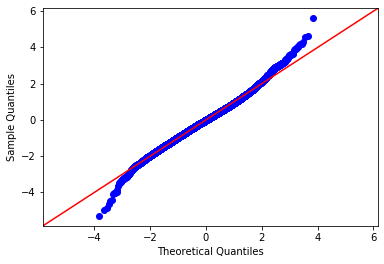

In [17]:
ut.qqplot(model)

And let's take another look at our sqft_living variable after the log transformation. As you can see, we've removed most of the heteroscedasticity and the residuals for that variable are starting look more normally distributed. This is confirmed when we reexamine the regress plot for sqft_living.

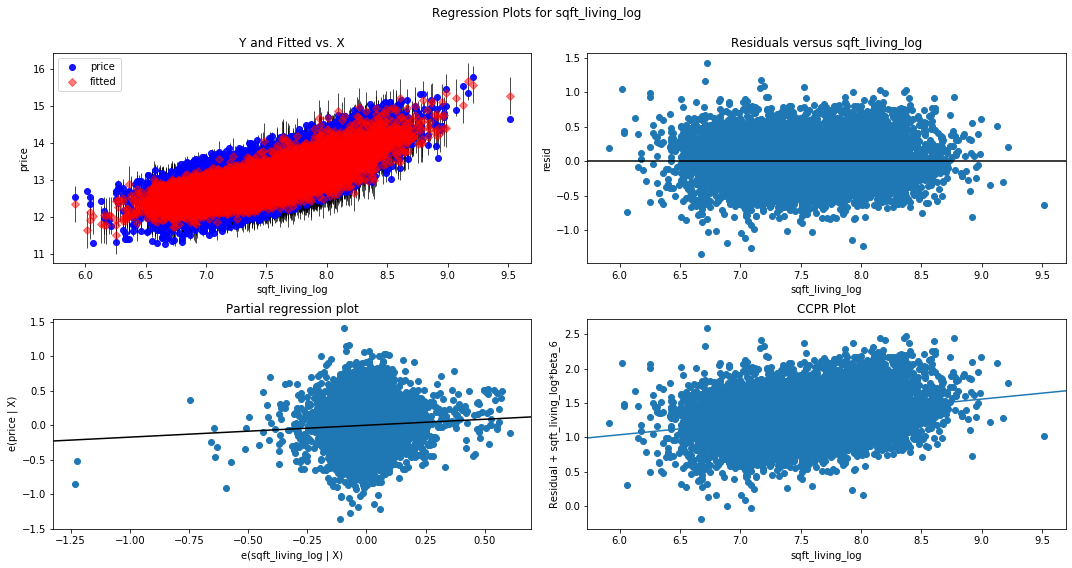

In [18]:
ut.regress_plots(['sqft_living_log'], model)

## Model 3: One Hot Encoding Categoricals


At the moment, our model is only using continuous data, and not categorical. To change that, we want to one-hot encode our categoricals to make sure they are read into the model correctly. I have identified the following variables that follow a categorical pattern:

    - bedrooms
    - bathrooms
    - floors
    - waterfront
    - condition
    - grade
    - zipcode

However, we should investigate if each variable needs to be preprocessed before we encode them into categorical columns. Below you can see a breakdown of each variable:

In [19]:
for x in categorical:
    print(f'{x} has {df[x].nunique()} unique values')

bedrooms has 11 unique values
bathrooms has 29 unique values
floors has 6 unique values
waterfront has 2 unique values
condition has 5 unique values
grade has 11 unique values
zipcode has 70 unique values


### Model 3a: No Grouping
As you can see, each of these columns have fairly high number of categories if we don't preprocess the data. When we One Hot Encode these variables, it will add a massive number of columns to the dataframe. For our first categorical model, we're going to remove just the zipcode variable, but we'll keep the other variables in place for the moment.

Just to review, here is our current variable breakdown:

In [20]:
print('Continuous columns: ', continuous)
print('Categorical columns: ', categorical)
print('Log Transformed columns: ', logs)
print('Outcome column: ', outcome)

Continuous columns:  ['yr_built', 'yr_renovated', 'lat', 'long', 'sqft_basement']
Categorical columns:  ['bedrooms', 'bathrooms', 'floors', 'waterfront', 'condition', 'grade', 'zipcode']
Log Transformed columns:  ['sqft_living_log', 'sqft_lot_log', 'sqft_above_log', 'sqft_living15_log', 'sqft_lot15_log']
Outcome column:  price


We're going to remove the zipcode variable from the categorical variables

In [21]:
categorical.remove('zipcode')

In this business program, we are advising a development company that specializes in new construction. Therefore, we want to know how much does recent construction affect the eventual sale price of the home? Obviously they can't travel into the past to build homes in 1925, unless they have some technology we don't know about (wow, that would be the least interesting sci-fi movie of all time), so we want to know if homes built or renovated in the last ten years have a significant effect on the sale price in either direction. Therefore, we'll add a boolean column 'Recent_Construction' to the dataset and add that to the categorical columns.

In [22]:
df['Recent_Construction'] = False
df['Recent_Construction'] = df.loc[(df.yr_built >= 2004) | (df.yr_renovated >= 2004)].Recent_Construction.map(lambda x: True)
df.Recent_Construction.fillna(False,inplace=True)
categorical.append('Recent_Construction')
continuous.remove('yr_built')
continuous.remove('yr_renovated')

We can now One Hot Encode the following columns while dropping the first column to ensure we don't cause any further multicollinearity (which we will deal with in the next model). We will build these new columns using the Pandas get_dummies function.

In [23]:
print('Continuous columns: ', continuous)
print('Categorical columns: ', categorical)
print('Log Transformed columns: ', logs)
print('Outcome column: ', outcome)

Continuous columns:  ['lat', 'long', 'sqft_basement']
Categorical columns:  ['bedrooms', 'bathrooms', 'floors', 'waterfront', 'condition', 'grade', 'Recent_Construction']
Log Transformed columns:  ['sqft_living_log', 'sqft_lot_log', 'sqft_above_log', 'sqft_living15_log', 'sqft_lot15_log']
Outcome column:  price


In [24]:
cat_dfs = []

for column in categorical:
    cat_dfs.append(pd.get_dummies(df[column], prefix=column[:3], drop_first=True))

ohe_df = pd.concat(cat_dfs, axis=1)

ohe_cols = ohe_df.columns.to_list()

df_ohe_a = pd.concat([df, ohe_df], axis=1)

Now that we have those categorical variables one hot encoded we can see how this transformation has affected our model.

Training Scores:
R2: 0.7512799195229647
Root Mean Squared Error: 186153.0304701355
Mean Absolute Error: 113717.97749669217
---
Testing Scores:
R2: 0.7527375362233333
Root Mean Squared Error: 212392.9220984744
Mean Absolute Error: 116617.3517307566


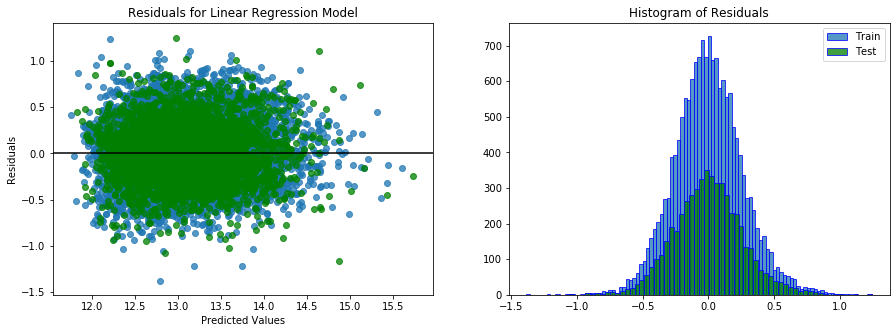

LinearRegression()

In [25]:
predictors = continuous + ohe_cols + logs
ut.sk_linear_regression(df_ohe_a, predictors, outcome, log=True)

In [26]:
model = ut.sm_linear_regression(df_ohe_a, predictors, outcome, log=True)
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.751
Model:                            OLS   Adj. R-squared:                  0.750
Method:                 Least Squares   F-statistic:                     749.6
Date:                Sat, 30 Jan 2021   Prob (F-statistic):               0.00
Time:                        16:25:29   Log-Likelihood:                -1277.3
No. Observations:               16197   AIC:                             2687.
Df Residuals:                   16131   BIC:                             3194.
Df Model:                          65                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const               -84.8827      2.337    -36.315      0.000     -89.464     -80.301
lat                   1.3999      0.016     88.844      0.000       1.369       1.431
long                 -0.2181      0.018    -12.106      0.000      -0.253      -0.183
sqft_basement      9.136e-05   1.32e-05      6.903      0.000    6.54e-05       0.000
bed_2                -0.0328      0.024     -1.366      0.172      -0.080       0.014
bed_3                -0.1061      0.024     -4.379      0.000      -0.154      -0.059
bed_4                -0.1314      0.025     -5.287      0.000      -0.180      -0.083
bed_5                -0.1456      0.026     -5.588      0.000      -0.197      -0.095
bed_6                -0.1608      0.031     -5.147      0.000      -0.222      -0.100
bed_7                -0.2300      0.055     -4.149      0.000      -0.339      -0.121
bed_8                -0.2063      0.098     -2.113      0.035      -0.398      -0.015
bed_9                -0.1837      0.156     -1.175      0.240      -0.490       0.123
bed_10               -0.1245      0.156     -0.796      0.426      -0.431       0.182
bed_11               -0.0198      0.264     -0.075      0.940      -0.537       0.498
bat_0.75              0.1983      0.157      1.266      0.205      -0.109       0.505
bat_1.0               0.1877      0.152      1.235      0.217      -0.110       0.486
bat_1.25              0.2074      0.186      1.116      0.264      -0.157       0.572
bat_1.5               0.1649      0.152      1.084      0.278      -0.133       0.463
bat_1.75              0.1905      0.152      1.254      0.210      -0.107       0.488
bat_2.0               0.2000      0.152      1.316      0.188      -0.098       0.498
bat_2.25              0.1652      0.152      1.086      0.277      -0.133       0.463
bat_2.5               0.1489      0.152      0.980      0.327      -0.149       0.447
bat_2.75              0.1875      0.152      1.232      0.218      -0.111       0.486
bat_3.0               0.2080      0.152      1.365      0.172      -0.091       0.507
bat_3.25              0.2405      0.153      1.576      0.115      -0.059       0.540
bat_3.5               0.2327      0.153      1.526      0.127      -0.066       0.532
bat_3.75              0.3060      0.154      1.986      0.047       0.004       0.608
bat_4.0               0.2646      0.155      1.713      0.087      -0.038       0.567
bat_4.25              0.3170      0.156      2.027      0.043       0.010       0.623
bat_4.5               0.2928      0.156      1.881      0.060      -0.012       0.598
bat_4.75              0.4544      0.166      2.741      0.006       0.130       0.779
bat_5.0               0.3704      0.165      2.238      0.025       0.046       0.695
bat_5.25              0.5088      0.175      2.914      0.004       0.167

With this iteration of the model we seem to have taken a step backwards in terms of accuracy. We're very slighty underfit on this, due to the fact that the testing data has a better R2 score than the training data, but the difference isn't large. However, we need to reassess this current categorical set up because, as we can see from the summary, there are a number of variables with a p value greater than our alpha of 0.05, meaning we cannot reject the null hypothesis that they are in fact equal to zero. This is a good indication that our categorical variables need some help.

Let's take a quick look at our residuals and see if they are any more normal

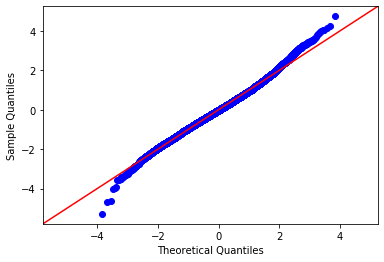

In [27]:
ut.qqplot(model)

That's looking a little better! While our model isn't any more accurate, we are getting closer. We're going to reassess those categoricals next.

### Model 3b: Grouping by Quartile
If we treat each of these variables as a purely categorical variable, we add an unwieldy number of columns to the final preprocessed dataframe. Both Bathrooms and Zipcode have an excessive number of unique values. We're going to set zipcode aside for the moment, but if we break down bathrooms via value counts, we can see a wide range of values:

In [28]:
df.floors.value_counts()

1.0    10673
2.0     8235
1.5     1910
3.0      611
2.5      161
3.5        7
Name: floors, dtype: int64

For each column in the categorical list, we're going to create buckets with the following rubric. We want 'low', 'medium' and 'high' values for each variable where low represents the lowest quartile, high represents the highest quartile and medium represents the rest of the data. This intentionally weights the category to the median. If we examine a breakdown of the columns, we can see the boundaries of each bucket.

In [29]:
df[categorical].describe()

,bedrooms,bathrooms,floors,waterfront,condition,grade
count,21597.000000,21597.000000,21597.000000,21597.000000,21597.000000,21597.000000
mean,3.371811,2.115826,1.494096,0.006760,3.409825,7.657915
std,0.904096,0.768984,0.539683,0.081944,0.650546,1.173200
min,1.000000,0.500000,1.000000,0.000000,1.000000,3.000000
25%,3.000000,1.750000,1.000000,0.000000,3.000000,7.000000
50%,3.000000,2.250000,1.500000,0.000000,3.000000,7.000000
75%,4.000000,2.500000,2.000000,0.000000,4.000000,8.000000
max,11.000000,8.000000,3.500000,1.000000,5.000000,13.000000


Based on this breakdown, the mid-range of each variable would be:

- **Bedrooms** - 3-4 bedrooms
- **Bathrooms** - 1.75-2.25 bathrooms
- **Condition** - 3-4
- **Grade** - 7-8

Note: Waterfront is a Boolean and therefore does not need to be processed. Also, for floors, we're going to organize the houses into the following categories:

- 1-1.5 Floors = Bungalow
- 2-2.5 Floors = House
- 3+ Floors = Townhouse

For condition and grade, we will organize by Bad, Fine, and Good.

In [30]:
def floors(value):
    
    if value <= 1.5:
        return 'BUN'
    elif 1.5 < value <= 2.5:
        return 'HOU'
    else:
        return 'TOW'

In [31]:
df['Building'] = df.floors.map(lambda x: floors(x))
df.Building.value_counts()

BUN    12583
HOU     8396
TOW      618
Name: Building, dtype: int64

In [32]:
def bathrooms(value):
    if value < 1.75:
        return 'Low'
    elif 1.75 <= value <= 2.25:
        return 'Med'
    else:
        return 'High'

In [33]:
df['Baths'] = df.bathrooms.map(lambda x: bathrooms(x))
df.Baths.value_counts()

High    9192
Med     7025
Low     5380
Name: Baths, dtype: int64

In [34]:
def bedrooms(value):
    if value < 3:
        return 'SM'
    elif 3 <= value <= 4:
        return 'MED'
    else:
        return 'LRG'

In [35]:
df['Beds'] = df.bedrooms.map(lambda x: bedrooms(x))
df.Beds.value_counts()

MED    16707
SM      2956
LRG     1934
Name: Beds, dtype: int64

In [36]:
def condition(value):
    if value < 3:
        return 'Bad'
    elif 3 <= value <= 4:
        return 'Fine'
    else:
        return 'Good'

In [37]:
df['Cond'] = df.condition.map(lambda x: condition(x))
df.Cond.value_counts()

Fine    19697
Good     1701
Bad       199
Name: Cond, dtype: int64

In [38]:
def grade(value):
    if value < 7:
        return 'Bad'
    elif 7 <= value <= 8:
        return 'Fine'
    else:
        return 'Good'

In [39]:
df['Grade'] = df.grade.map(lambda x: grade(x))
df.Grade.value_counts()

Fine    15039
Good     4250
Bad      2308
Name: Grade, dtype: int64

In [40]:
new_cats = ['Grade', 'Cond', 'Beds', 'Baths', 'Building', 'waterfront', 'Recent_Construction']

In [41]:
cat_dfs = []

for column in new_cats:
    cat_dfs.append(pd.get_dummies(df[column], prefix=column[:3], drop_first=True))

ohe_df = pd.concat(cat_dfs, axis=1)
ohe_cols = ohe_df.columns.to_list()

df_ohe_b = pd.concat([df, ohe_df], axis=1)

We have our variables in the three buckets each, lets see how they do in the new model.

Training Scores:
R2: 0.7211548753652239
Root Mean Squared Error: 204769.53475742828
Mean Absolute Error: 122569.23794642223
---
Testing Scores:
R2: 0.7203869365135834
Root Mean Squared Error: 232238.6959873845
Mean Absolute Error: 126537.5634317603


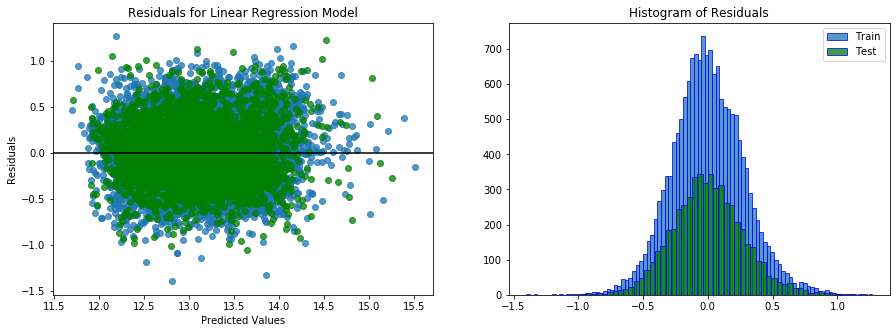

LinearRegression()

In [42]:
predictors = continuous + ohe_cols + logs
ut.sk_linear_regression(df_ohe_b, predictors, outcome, log=True)

In [43]:
model = ut.sm_linear_regression(df_ohe_b, predictors, outcome, log=True)
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.721
Model:                            OLS   Adj. R-squared:                  0.721
Method:                 Least Squares   F-statistic:                     2092.
Date:                Sat, 30 Jan 2021   Prob (F-statistic):               0.00
Time:                        16:25:31   Log-Likelihood:                -2203.2
No. Observations:               16197   AIC:                             4448.
Df Residuals:                   16176   BIC:                             4610.
Df Model:                          20                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const               -99.7824      2.405    -41.488      0.000    -104.497     -95.068
lat                   1.4473      0.016     87.762      0.000       1.415       1.480
long                 -0.3087      0.019    -16.426      0.000      -0.346      -0.272
sqft_basement         0.0002   1.32e-05     13.103      0.000       0.000       0.000
Gra_Fine              0.1131      0.008     13.371      0.000       0.097       0.130
Gra_Good              0.3830      0.012     32.302      0.000       0.360       0.406
Con_Fine              0.1479      0.023      6.383      0.000       0.103       0.193
Con_Good              0.2941      0.024     12.078      0.000       0.246       0.342
Bed_MED               0.0182      0.008      2.220      0.026       0.002       0.034
Bed_SM                0.1131      0.011     10.005      0.000       0.091       0.135
Bat_Low               0.0166      0.009      1.895      0.058      -0.001       0.034
Bat_Med               0.0208      0.006      3.286      0.001       0.008       0.033
Bui_HOU              -0.0135      0.007     -1.931      0.054      -0.027       0.000
Bui_TOW               0.0295      0.015      1.927      0.054      -0.001       0.060
wat_1.0               0.6723      0.027     24.746      0.000       0.619       0.726
Rec_True              0.0217      0.007      3.115      0.002       0.008       0.035
sqft_living_log       0.1746      0.029      6.123      0.000       0.119       0.231
sqft_lot_log          0.0345      0.006      5.406      0.000       0.022       0.047
sqft_above_log        0.3374      0.025     13.303      0.000       0.288       0.387
sqft_living15_log     0.3011      0.011     27.279      0.000       0.280       0.323
sqft_lot15_log       -0.0587      0.007     -8.555      0.000      -0.072      -0.045
==============================================================================
Omnibus:                      157.302   Durbin-Watson:                   2.006
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              213.115
Skew:                           0.137   Prob(JB):                     5.28e-47
Kurtosis:                       3.490   Cond. No.                     5.86e+05
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 5.86e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

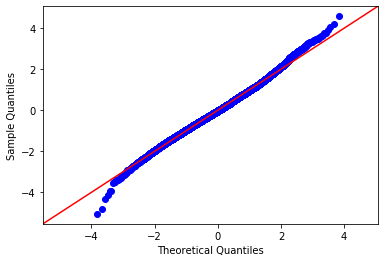

In [44]:
ut.qqplot(model)

From our R2 scores, we can see that this is too far a step backwards in terms of accuracy, even if our residuals are starting to look even more normal. Perhaps we don't have enough buckets for the various categories. Let's tweak them a little.

In [45]:
# We are going to differentiate between 'Apartment' and 'Bungalow' this time on the floors function.

def floors2(value):
    
    if value <= 1:
        return 'APT'
    elif value == 1.5:
        return 'BUN'
    else:
        return 'HOU'
    
df['Building'] = df.floors.map(lambda x: floors2(x))
df.Building.value_counts()

APT    10673
HOU     9014
BUN     1910
Name: Building, dtype: int64

In [46]:
# Because 3 is the mode number of bedrooms, we can shift 4 bedrooms into 'big'

def bedrooms2(value):
    if value < 3:
        return 'SM'
    elif value == 3:
        return 'MED'
    else:
        return 'BIG'
    
df['Beds'] = df.bedrooms.map(lambda x: bedrooms2(x))
df.Beds.value_counts()

MED    9825
BIG    8816
SM     2956
Name: Beds, dtype: int64

In [47]:
# Since 3 is the mode condition, we can split into 4 categories to see if that increases model accuracy. 

def condition2(value):
    if value < 3:
        return 'Bad'
    elif value == 3:
        return 'Okay'
    elif value == 4:
        return 'Fine'
    else:
        return 'Good'

df['Cond'] = df.condition.map(lambda x: condition2(x))
df.Cond.value_counts()

Okay    14020
Fine     5677
Good     1701
Bad       199
Name: Cond, dtype: int64

In [48]:
# 8 is the mode score, so we get a more even distribution of buckets if we split 7 and 8 into two categories.

def grade2(value):
    if value < 7:
        return 'Bad'
    elif value == 7:
        return 'Okay'
    elif value == 8:
        return 'Fine'
    else:
        return 'Good'

df['Grade'] = df.grade.map(lambda x: grade2(x))
df.Grade.value_counts()

Okay    8974
Fine    6065
Good    4250
Bad     2308
Name: Grade, dtype: int64

Let's see how these new buckets do with our model.

In [49]:
cat_dfs = []

for column in new_cats:
    cat_dfs.append(pd.get_dummies(df[column], prefix=column[:3], drop_first=True))

ohe_df = pd.concat(cat_dfs, axis=1)
ohe_cols = ohe_df.columns.to_list()

df_ohe_c = pd.concat([df, ohe_df], axis=1)

Training Scores:
R2: 0.7360031164694955
Root Mean Squared Error: 204036.28435801837
Mean Absolute Error: 118985.99690042852
---
Testing Scores:
R2: 0.7352975390824168
Root Mean Squared Error: 232361.5844080497
Mean Absolute Error: 122987.07790036789


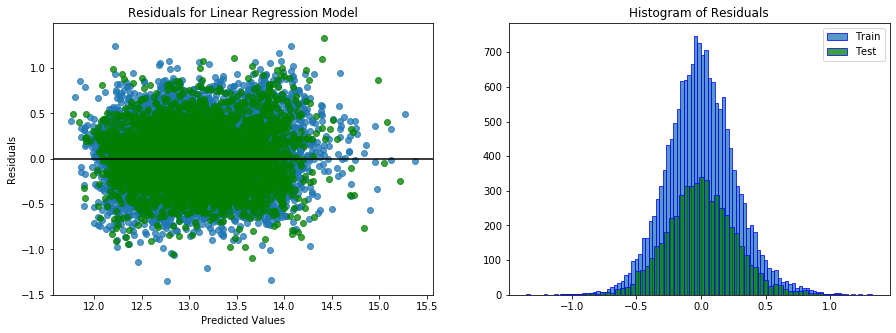

LinearRegression()

In [50]:
predictors = continuous + ohe_cols + logs
ut.sk_linear_regression(df_ohe_c, predictors, outcome, log=True)

In [51]:
model = ut.sm_linear_regression(df_ohe_c, predictors, outcome, log=True)
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.736
Model:                            OLS   Adj. R-squared:                  0.736
Method:                 Least Squares   F-statistic:                     2050.
Date:                Sat, 30 Jan 2021   Prob (F-statistic):               0.00
Time:                        16:25:32   Log-Likelihood:                -1760.1
No. Observations:               16197   AIC:                             3566.
Df Residuals:                   16174   BIC:                             3743.
Df Model:                          22                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const               -93.1780      2.343    -39.763      0.000     -97.771     -88.585
lat                   1.4296      0.016     88.945      0.000       1.398       1.461
long                 -0.2658      0.018    -14.532      0.000      -0.302      -0.230
sqft_basement         0.0002   1.27e-05     12.169      0.000       0.000       0.000
Gra_Fine              0.2328      0.010     23.405      0.000       0.213       0.252
Gra_Good              0.4860      0.012     39.232      0.000       0.462       0.510
Gra_Okay              0.1087      0.008     13.143      0.000       0.092       0.125
Con_Fine              0.1961      0.023      8.605      0.000       0.151       0.241
Con_Good              0.2845      0.024     12.004      0.000       0.238       0.331
Con_Okay              0.1079      0.023      4.763      0.000       0.063       0.152
Bed_MED               0.0313      0.005      5.859      0.000       0.021       0.042
Bed_SM                0.1207      0.009     13.639      0.000       0.103       0.138
Bat_Low               0.0267      0.009      3.099      0.002       0.010       0.044
Bat_Med               0.0193      0.006      3.110      0.002       0.007       0.031
Bui_BUN               0.1127      0.008     13.668      0.000       0.097       0.129
Bui_HOU               0.0149      0.007      2.070      0.038       0.001       0.029
wat_1.0               0.6654      0.026     25.143      0.000       0.614       0.717
Rec_True              0.0340      0.007      4.983      0.000       0.021       0.047
sqft_living_log       0.2044      0.028      7.308      0.000       0.150       0.259
sqft_lot_log          0.0410      0.006      6.609      0.000       0.029       0.053
sqft_above_log        0.2532      0.025     10.213      0.000       0.205       0.302
sqft_living15_log     0.2703      0.011     24.759      0.000       0.249       0.292
sqft_lot15_log       -0.0595      0.007     -8.905      0.000      -0.073      -0.046
==============================================================================
Omnibus:                      247.774   Durbin-Watson:                   2.010
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              366.676
Skew:                           0.174   Prob(JB):                     2.38e-80
Kurtosis:                       3.649   Cond. No.                     5.87e+05
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 5.87e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

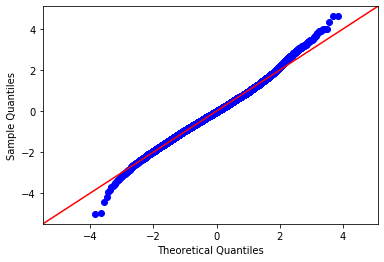

In [52]:
ut.qqplot(model)

We're now looking at an R2 of 0.736 and both the testing and training data have similar errors. With these tweaks to our buckets, our QQ Plot looks a little less normal, but we still have to handle multicollinearity. While our model has dipped in accuracy from our high of an R2 of 76%, we are now treating categoricals as they should be.

## Model 4: Variable Interactions



In a model like this, multicollinearity can be a huge problem because we want to know how each variable affects our outcome metric and to confirm that, we need to ensure that the variables are independent. First, we can examine the correlations between our variables using a heat map. Let's examine the continuous variables first:

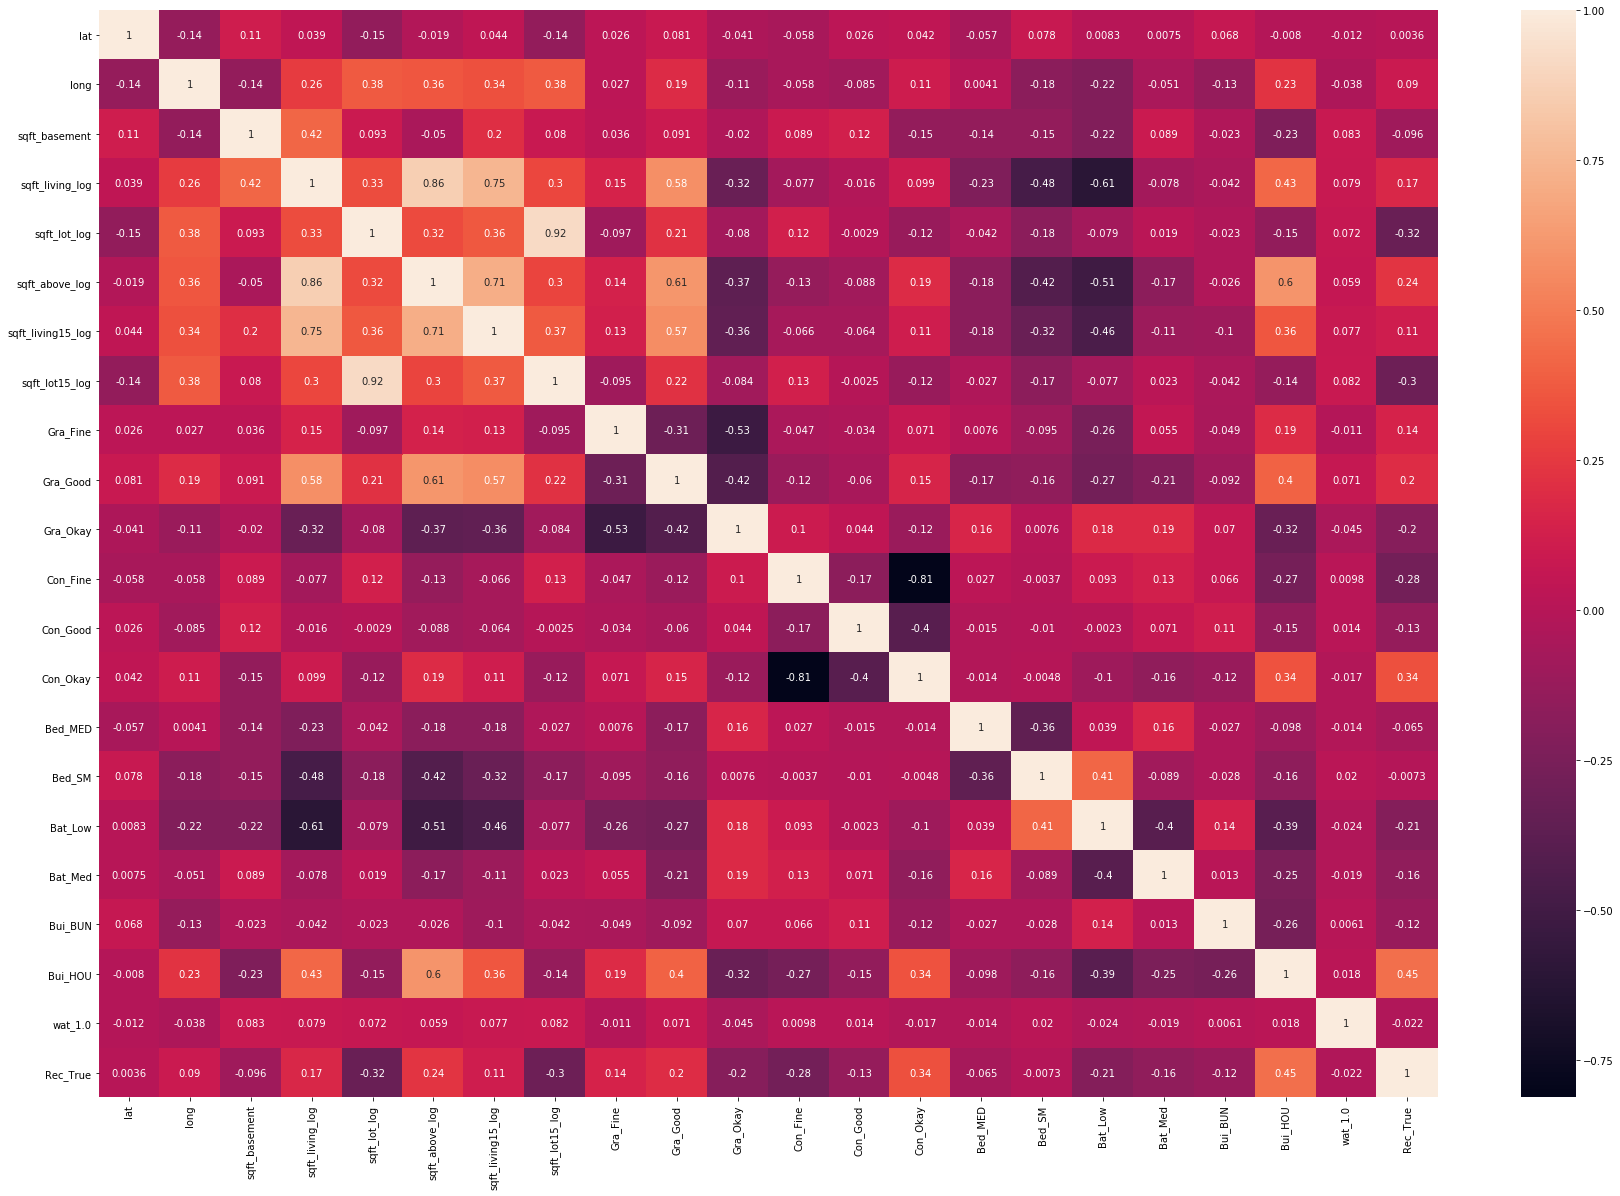

In [53]:
plt.figure(figsize=(30,20))
ax = sns.heatmap(df_ohe_c[continuous+logs+ohe_cols].corr(), annot=True)
ax.set_ylim(22, 0);

Any correlation coefficient greater than 0.70 could cause issues. We can see a few issues immediately, all of which make a reasonable amount of sense:

    - sqft_lot_log vs. sqft_lot15_log = 0.92
    - sqft_living_log vs. sqft_above_log = 0.86
    - sqft_living_log vs. sqft_living15_log = 0.75
    - sqft_living15_log vs. sqft_above_log = 0.71

This makes sense. By including both variables sqft_living (a measure of the living area square footage) and sqft_above (a measure of the square footage above ground), we are essentially counting the same variable twice. Most homes have the majority of their square footage above ground and that tends to be the living area. 

Then, if we look at sqft_lot_log (a measure of the lot's square footage) vs. sqft_lot15_log (the mean of the square footage of 15 neighbors) it tracks that homes with large lots will be located near other homes with large lots.

It's reasonable then to drop some of these columns to help the model. As a developer, most of the time they won't be able to control the lot size of the closest 15 neighbors and, in general, most buildings in a neighborhood will have similar footprints and layouts. Because of that, we can drop both the sqft_living15_log and the sqft_lot15_log columns without losing any key information. We can also drop square footage above ground because square foot of the living area is far more important and illuminating.

In [54]:
for col in ['sqft_living15_log', 'sqft_lot15_log', 'sqft_above_log']:
    logs.remove(col)
print(logs)

['sqft_living_log', 'sqft_lot_log']


Training Scores:
R2: 0.7233799030007039
Root Mean Squared Error: 211822.8593470417
Mean Absolute Error: 121724.56164815006
---
Testing Scores:
R2: 0.7216723026026204
Root Mean Squared Error: 242043.9204982168
Mean Absolute Error: 125766.56118829093


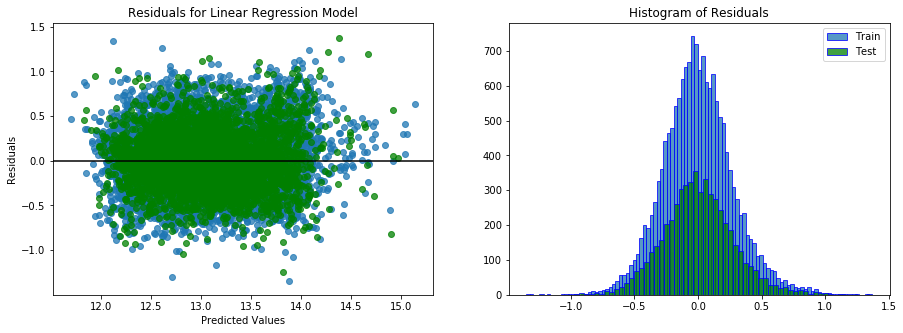

LinearRegression()

In [55]:
df_int = df_ohe_c
predictors = continuous+ohe_cols+logs
ut.sk_linear_regression(df_int, predictors, outcome, log=True)

In [56]:
continuous.remove('sqft_basement')

In [57]:
model = ut.sm_linear_regression(df_int, predictors, outcome, log=True)
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.723
Model:                            OLS   Adj. R-squared:                  0.723
Method:                 Least Squares   F-statistic:                     2227.
Date:                Sat, 30 Jan 2021   Prob (F-statistic):               0.00
Time:                        16:25:35   Log-Likelihood:                -2138.3
No. Observations:               16197   AIC:                             4317.
Df Residuals:                   16177   BIC:                             4470.
Df Model:                          19                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const             -84.7541      2.360    -35.919      0.000     -89.379     -80.129
lat                 1.4468      0.016     88.136      0.000       1.415       1.479
long               -0.1978      0.018    -10.742      0.000      -0.234      -0.162
sqft_basement    3.221e-05   6.89e-06      4.673      0.000    1.87e-05    4.57e-05
Gra_Fine            0.2770      0.010     27.620      0.000       0.257       0.297
Gra_Good            0.5680      0.012     46.356      0.000       0.544       0.592
Gra_Okay            0.1210      0.008     14.335      0.000       0.104       0.138
Con_Fine            0.1725      0.023      7.406      0.000       0.127       0.218
Con_Good            0.2542      0.024     10.496      0.000       0.207       0.302
Con_Okay            0.0866      0.023      3.740      0.000       0.041       0.132
Bed_MED             0.0293      0.005      5.368      0.000       0.019       0.040
Bed_SM              0.1319      0.009     14.579      0.000       0.114       0.150
Bat_Low             0.0275      0.009      3.145      0.002       0.010       0.045
Bat_Med             0.0085      0.006      1.346      0.178      -0.004       0.021
Bui_BUN             0.1148      0.008     13.744      0.000       0.098       0.131
Bui_HOU             0.0219      0.007      3.029      0.002       0.008       0.036
wat_1.0             0.6869      0.027     25.422      0.000       0.634       0.740
Rec_True            0.0267      0.007      3.829      0.000       0.013       0.040
sqft_living_log     0.5709      0.012     47.576      0.000       0.547       0.594
sqft_lot_log        0.0071      0.003      2.169      0.030       0.001       0.014
==============================================================================
Omnibus:                      385.660   Durbin-Watson:                   2.018
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              570.611
Skew:                           0.257   Prob(JB):                    1.24e-124
Kurtosis:                       3.762   Cond. No.                     5.78e+05
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 5.78e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

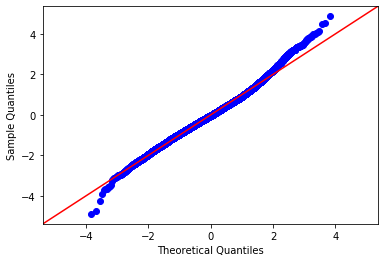

In [58]:
ut.qqplot(model)

As you can see from the summary above, this hasn't affected our R2 score too much. We're still hovering at around .723, meaning that we can account for about 72% of the variance in the data. According to the summary, we still have a strong possibility of multicollinearity. If we examine our correlation coefficient heatmap once more, we can see the highest Pearson coefficient is 0.58 between 'Grade: Good' and sqft_living_log, but that value is small enough that it shouldn't cause issue.

(18, 0)

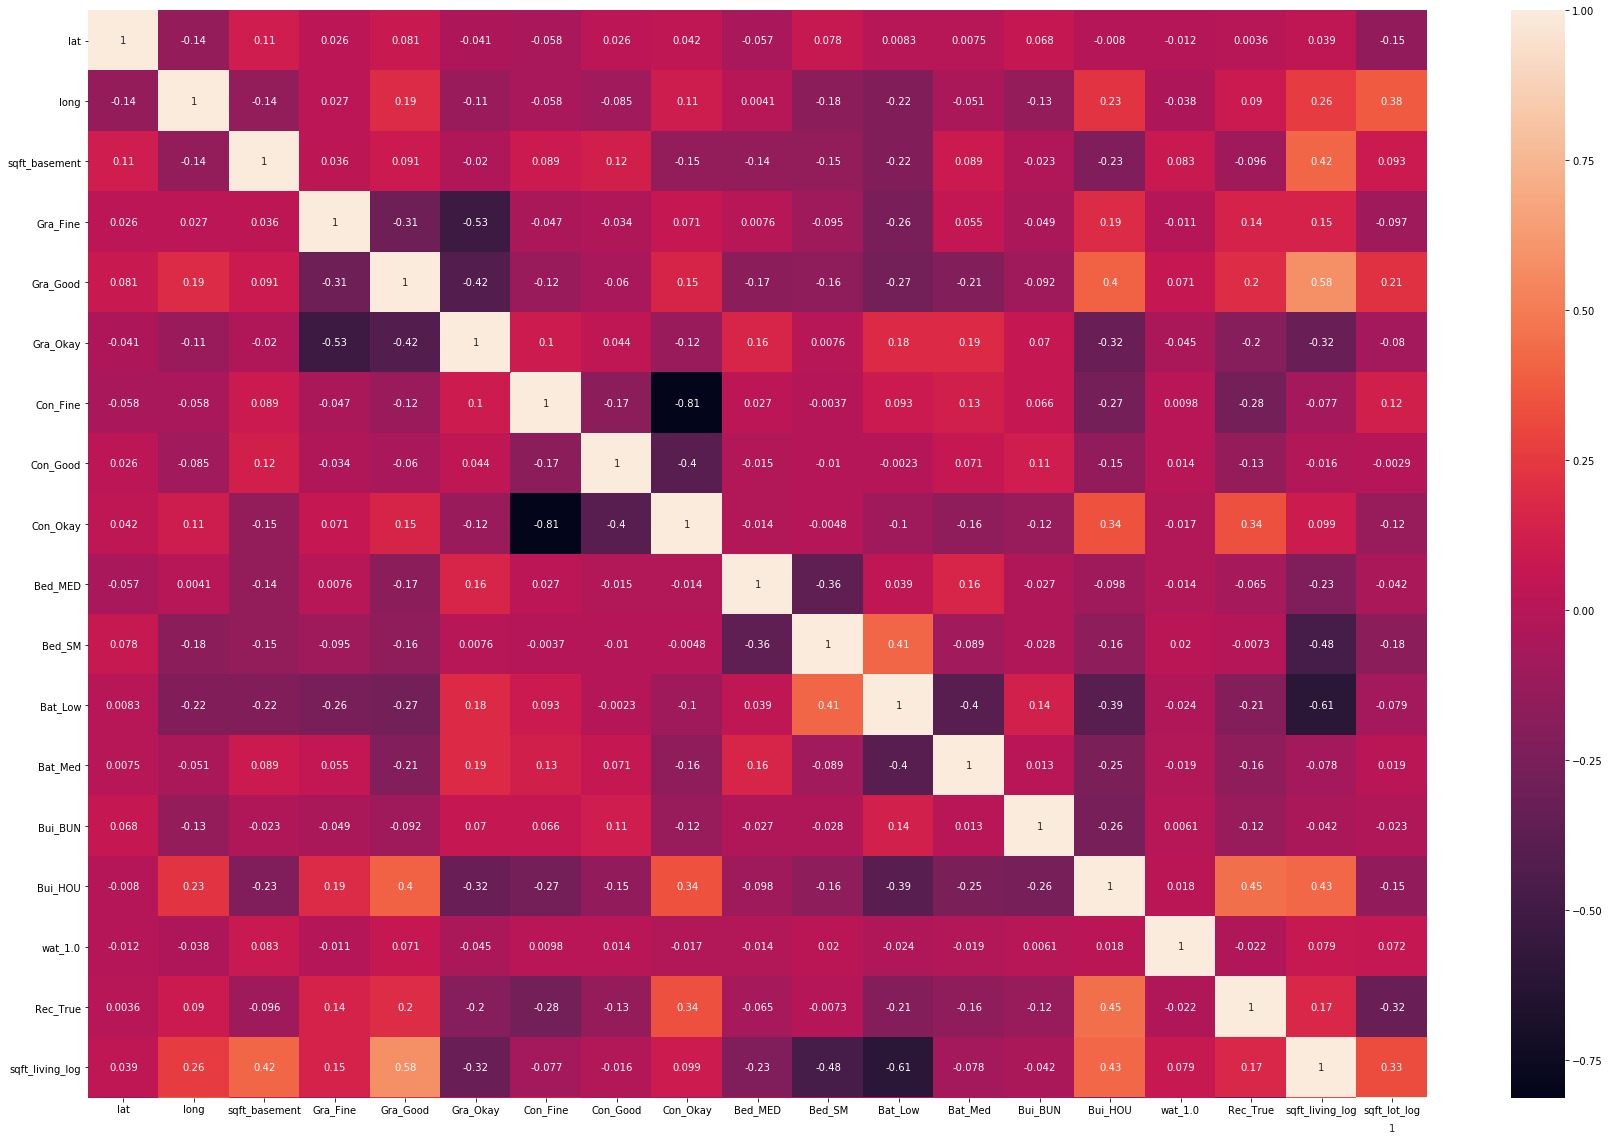

In [59]:
plt.figure(figsize=(30,20))
ax = sns.heatmap(df_ohe_c[predictors].corr(), annot=True);
ax.set_ylim(18, 0)

Before we scale the data to measure coefficient impact, we have two more approaches to attempt to see if we can increase our R2 score.

## Model 5: Zipcode Clusters

Anyone who has bought a home knows that neighborhood can be extremely impactful on the price of your home. Right now, the only measure of this impact that our model considers is in the latitude and longitude. We have two ways of handling the question of where the property is located: neighborhood clusters and distance from the city center.

![seattle](Images/city_map.jpg)

### Model 5a: First Attempt
Using the website zipmap.net, I categorized each zipcode into their respective townships (different towns have different local governments, so housing prices might reflect deltas in taxation, school quality etc.). Any neighborhood within the downtown Seattle area are labeled 'Seattle' and any properties still within the City of Seattle but outside of downtown are labeled either N Seattle or S Seattle.

In [60]:
zipcode_dict = {
    98178: 'Seattle',
    98125: 'Seattle',
    98028: 'Kenmore',
    98136: 'Seattle',
    98074: 'Sammamish',
    98053: 'Redmond',
    98003: 'Federal Way',
    98198: 'S Seattle',
    98146: 'S Seattle',
    98038: 'Maple Valley',
    98007: 'Bellevue',
    98115: 'Seattle',
    98107: 'Seattle',
    98126: 'Seattle',
    98019: 'Duvall',
    98103: 'Seattle',
    98002: 'Auburn',
    98133: 'Seattle',
    98040: 'Mercer',
    98092: 'Auburn',
    98030: 'Kent',
    98119: 'Seattle',
    98112: 'Seattle',
    98052: 'Redmond',
    98027: 'Issaquah',
    98117: 'Seattle',
    98058: 'Renton',
    98001: 'Auburn', 
    98056: 'Renton', 
    98166: 'S Seattle', 
    98023: 'Federal Way', 
    98070: 'Vashon', 
    98148: 'Seattle', 
    98105: 'Seattle', 
    98042: 'Kent', 
    98008: 'Bellevue',
    98059: 'Renton', 
    98122: 'Seattle', 
    98144: 'Seattle', 
    98004: 'Bellevue', 
    98005: 'Bellevue', 
    98034: 'Kirkland', 
    98075: 'Sammamish', 
    98116: 'Seattle', 
    98010: 'Black Diamond',
    98118: 'Seattle', 
    98199: 'Seattle', 
    98032: 'Kent', 
    98045: 'North Bend', 
    98102: 'Seattle', 
    98077: 'Woodinville', 
    98108: 'Seattle', 
    98168: 'S Seattle', 
    98177: 'N Seattle',
    98065: 'Snoqualmie', 
    98029: 'Issaquah', 
    98006: 'Bellevue', 
    98109: 'Seattle', 
    98022: 'Enumclaw', 
    98033: 'Kirkland', 
    98155: 'N Seattle', 
    98024: 'Fall City', 
    98011: 'Bothell',
    98031: 'Kent', 
    98106: 'Seattle', 
    98072: 'Woodinville', 
    98188: 'S Seattle', 
    98014: 'Carnation', 
    98055: 'Renton', 
    98039: 'Medina'
}

In [61]:
df['Area'] = df.zipcode.map(lambda x: zipcode_dict[x])
print('Number of neighborhoods:', df.Area.nunique())
df.Area.value_counts()

Number of neighborhoods: 26


Seattle          7045
Renton           1597
Bellevue         1407
S Seattle        1227
Kent             1201
Redmond           977
Kirkland          977
Auburn            911
Sammamish         800
Federal Way       779
Issaquah          733
N Seattle         701
Maple Valley      589
Woodinville       471
Snoqualmie        308
Kenmore           283
Mercer            282
Enumclaw          233
North Bend        220
Bothell           195
Duvall            190
Carnation         124
Vashon            117
Black Diamond     100
Fall City          80
Medina             50
Name: Area, dtype: int64

First, let's attempt to one hot encode these neighborhoods and see how our model responds.

In [62]:
ohe_Area = pd.get_dummies(df.Area, prefix='Are', drop_first=True)

Area_cols = ohe_Area.columns.to_list()

df_ohe_d = pd.concat([df_ohe_c, ohe_Area], axis=1)

Training Scores:
R2: 0.8047771316069448
Root Mean Squared Error: 177406.69465636724
Mean Absolute Error: 99056.35776543619
---
Testing Scores:
R2: 0.8092239764705162
Root Mean Squared Error: 192611.04486197903
Mean Absolute Error: 99222.74639262131


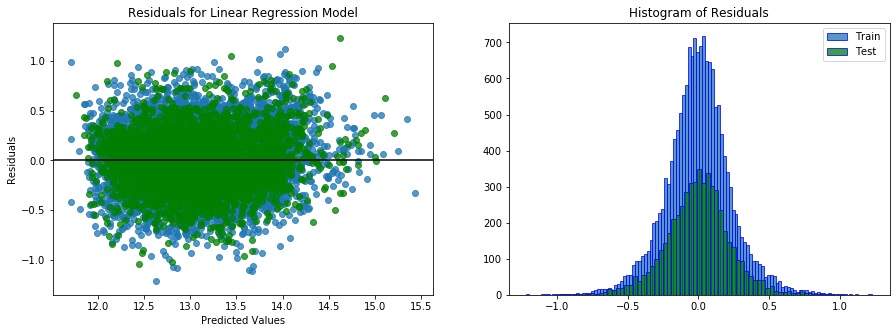

LinearRegression()

In [63]:
predictors = continuous + logs + ohe_cols + Area_cols
ut.sk_linear_regression(df_ohe_d, predictors, outcome, log=True)

In [64]:
model = ut.sm_linear_regression(df_ohe_d, predictors, outcome, log=True)
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.805
Model:                            OLS   Adj. R-squared:                  0.804
Method:                 Least Squares   F-statistic:                     1549.
Date:                Sat, 30 Jan 2021   Prob (F-statistic):               0.00
Time:                        16:25:38   Log-Likelihood:                 684.03
No. Observations:               16197   AIC:                            -1280.
Df Residuals:                   16153   BIC:                            -941.6
Df Model:                          43                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const              -144.2041      5.648    -25.531      0.000    -155.275    -133.133
lat                   1.1905      0.040     30.099      0.000       1.113       1.268
long                 -0.7803      0.045    -17.267      0.000      -0.869      -0.692
sqft_living_log       0.5500      0.009     62.514      0.000       0.533       0.567
sqft_lot_log          0.0600      0.003     19.895      0.000       0.054       0.066
Gra_Fine              0.2274      0.009     26.617      0.000       0.211       0.244
Gra_Good              0.4557      0.010     43.486      0.000       0.435       0.476
Gra_Okay              0.1030      0.007     14.402      0.000       0.089       0.117
Con_Fine              0.1780      0.020      9.070      0.000       0.140       0.216
Con_Good              0.2515      0.020     12.318      0.000       0.211       0.291
Con_Okay              0.1221      0.019      6.263      0.000       0.084       0.160
Bed_MED               0.0304      0.005      6.583      0.000       0.021       0.039
Bed_SM                0.0951      0.008     12.378      0.000       0.080       0.110
Bat_Low              -0.0054      0.007     -0.728      0.467      -0.020       0.009
Bat_Med              -0.0096      0.005     -1.793      0.073      -0.020       0.001
Bui_BUN               0.0787      0.007     11.263      0.000       0.065       0.092
Bui_HOU               0.0318      0.005      5.858      0.000       0.021       0.042
wat_1.0               0.6718      0.023     29.267      0.000       0.627       0.717
Rec_True              0.0399      0.006      6.740      0.000       0.028       0.051
Are_Bellevue          0.4803      0.017     28.672      0.000       0.447       0.513
Are_Black Diamond     0.3618      0.030     12.132      0.000       0.303       0.420
Are_Bothell          -0.1008      0.028     -3.657      0.000      -0.155      -0.047
Are_Carnation         0.1181      0.035      3.343      0.001       0.049       0.187
Are_Duvall            0.0136      0.031      0.441      0.659      -0.047       0.074
Are_Enumclaw          0.3555      0.022     15.970      0.000       0.312       0.399
Are_Fall City         0.3638      0.037      9.892      0.000       0.292       0.436
Are_Federal Way      -0.1004      0.014     -7.003      0.000      -0.128      -0.072
Are_Issaquah          0.3961      0.019     20.934      0.000       0.359       0.433
Are_Kenmore          -0.1491      0.025     -5.893      0.000      -0.199      -0.099
Are_Kent              0.0096      0.012      0.774      0.439      -0.015       0.034
Are_Kirkland          0.2060      0.020     10.255      0.000       0.167       0.245
Are_Maple Valley      0.2248      0.017     13.395      0.000       0.192       0.258
Are_Medina            0.9362      0.044     21.256      0.000       0.850

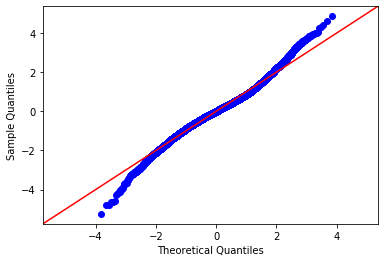

In [65]:
ut.qqplot(model)

Our R2 score just jumped to .809, which is the first significant jump in the model's accuracy since we log transformed. That said, we have increased our multicollinearity issues and our QQ plot of our residuals is looking less normal on the higher end. In our next attempt, we can cluster the neighborhoods a little more to see if that helps.

### Model 5b: Second Attempt
As we can see, there are 26 categories, which is fairly high. Below you can see one property from each 'neighborhood' overlaid on our heatmap of the Greater Seattle area. Here we can see we have a number of outliers east of North Bend. Let's try our model removing those outlier properties.

In [66]:
marker_dict = {}

for neighborhood in df.Area.unique():
    marker = (df.loc[df.Area == neighborhood].lat.to_list()[0], df.loc[df.Area == neighborhood].long.to_list()[0])
    marker_dict[neighborhood] = marker

for neighborhood in marker_dict.keys():
    folium.Marker([marker_dict[neighborhood][0], marker_dict[neighborhood][1]], popup=f'{neighborhood}').add_to(map_1)
map_1

We can see from an analysis of our Longitude values that Carnation is the neighborhood that is furthest east, so if we discount any markers beyond that boundary we only lose 14 properties. Let's see if removing those outliers helps.

In [67]:
df.groupby('Area').long.max().sort_values(ascending=False)

Area
Carnation       -121.315
North Bend      -121.417
Duvall          -121.473
Enumclaw        -121.646
Snoqualmie      -121.676
Fall City       -121.850
Black Diamond   -121.867
Issaquah        -121.900
Maple Valley    -121.936
Redmond         -121.953
Sammamish       -121.965
Auburn          -122.006
Woodinville     -122.012
Kent            -122.039
Renton          -122.063
Bellevue        -122.090
Kirkland        -122.145
Bothell         -122.167
Federal Way     -122.180
Mercer          -122.204
Kenmore         -122.220
Seattle         -122.220
Medina          -122.223
S Seattle       -122.258
N Seattle       -122.270
Vashon          -122.404
Name: long, dtype: float64

In [68]:
df_ohe_d = df_ohe_d.loc[df_ohe_d.long <= -121.317]

Training Scores:
R2: 0.8056608461532331
Root Mean Squared Error: 180610.40224094037
Mean Absolute Error: 98765.14059214207
---
Testing Scores:
R2: 0.806408576447123
Root Mean Squared Error: 184639.6900987637
Mean Absolute Error: 100104.92054029983


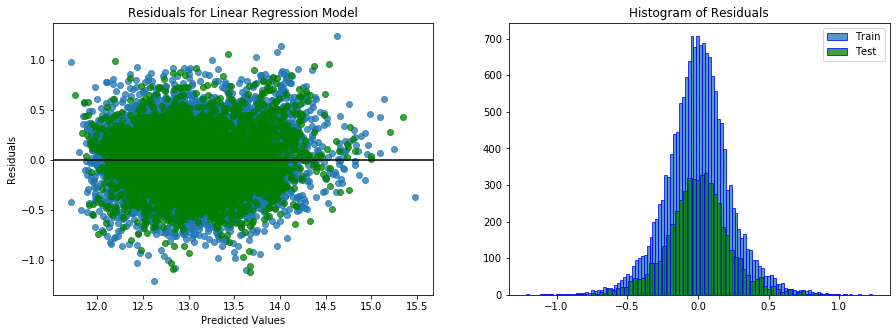

LinearRegression()

In [69]:
predictors = continuous + logs + ohe_cols + Area_cols
ut.sk_linear_regression(df_ohe_d, predictors, outcome, log=True)

In [70]:
model = ut.sm_linear_regression(df_ohe_d, predictors, outcome, log=True)
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.806
Model:                            OLS   Adj. R-squared:                  0.805
Method:                 Least Squares   F-statistic:                     1557.
Date:                Sat, 30 Jan 2021   Prob (F-statistic):               0.00
Time:                        16:25:39   Log-Likelihood:                 707.82
No. Observations:               16195   AIC:                            -1328.
Df Residuals:                   16151   BIC:                            -989.2
Df Model:                          43                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const              -147.1834      5.569    -26.427      0.000    -158.100    -136.267
lat                   1.1979      0.039     30.332      0.000       1.121       1.275
long                 -0.8020      0.045    -18.006      0.000      -0.889      -0.715
sqft_living_log       0.5457      0.009     62.232      0.000       0.529       0.563
sqft_lot_log          0.0614      0.003     20.361      0.000       0.055       0.067
Gra_Fine              0.2376      0.009     27.946      0.000       0.221       0.254
Gra_Good              0.4611      0.010     44.066      0.000       0.441       0.482
Gra_Okay              0.1108      0.007     15.609      0.000       0.097       0.125
Con_Fine              0.1727      0.020      8.771      0.000       0.134       0.211
Con_Good              0.2426      0.020     11.850      0.000       0.202       0.283
Con_Okay              0.1099      0.020      5.615      0.000       0.072       0.148
Bed_MED               0.0278      0.005      6.038      0.000       0.019       0.037
Bed_SM                0.0924      0.008     12.142      0.000       0.078       0.107
Bat_Low              -0.0041      0.007     -0.559      0.576      -0.019       0.010
Bat_Med              -0.0124      0.005     -2.324      0.020      -0.023      -0.002
Bui_BUN               0.0867      0.007     12.394      0.000       0.073       0.100
Bui_HOU               0.0331      0.005      6.073      0.000       0.022       0.044
wat_1.0               0.6744      0.023     29.480      0.000       0.630       0.719
Rec_True              0.0419      0.006      7.068      0.000       0.030       0.054
Are_Bellevue          0.4823      0.017     28.978      0.000       0.450       0.515
Are_Black Diamond     0.3850      0.030     13.052      0.000       0.327       0.443
Are_Bothell          -0.0923      0.028     -3.338      0.001      -0.146      -0.038
Are_Carnation         0.1236      0.035      3.525      0.000       0.055       0.192
Are_Duvall            0.0066      0.031      0.214      0.831      -0.053       0.067
Are_Enumclaw          0.3721      0.022     16.913      0.000       0.329       0.415
Are_Fall City         0.3912      0.037     10.576      0.000       0.319       0.464
Are_Federal Way      -0.1030      0.014     -7.219      0.000      -0.131      -0.075
Are_Issaquah          0.4066      0.019     21.666      0.000       0.370       0.443
Are_Kenmore          -0.1409      0.025     -5.548      0.000      -0.191      -0.091
Are_Kent              0.0117      0.012      0.952      0.341      -0.012       0.036
Are_Kirkland          0.2049      0.020     10.222      0.000       0.166       0.244
Are_Maple Valley      0.2266      0.017     13.510      0.000       0.194       0.259
Are_Medina            0.9732      0.041     23.545      0.000       0.892

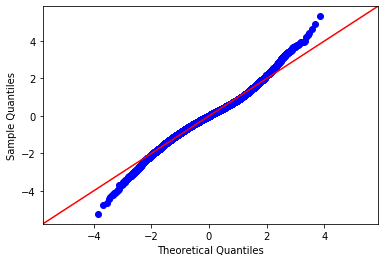

In [71]:
ut.qqplot(model)

A slight improvement, but we can do better. From our model summary, we can see that Duvall, Woodinville, Vashon, and Kent have p values greater than .05, our alpha, so let's see if we can incorporate them into other neighborhoods and see if that improve our model. Based on the closest neighborhood, we're going to class them thusly:

    Duvall -> Carnation
    Woodinville -> Kirkland
    Vashon -> Is an island, so we will keep it for now.
    Kent -> Auburn

In [72]:
edit_dict = {
    'Duvall': 'Carnation',
    'Woodinville': 'Kirkland',
    'Kent': 'Auburn'
            }

df['Area'] = df.Area.map(lambda x: edit_dict[x] if x in edit_dict.keys() else x)

In [73]:
ohe_Area = pd.get_dummies(df.Area, prefix='Are', drop_first=True)

Area_cols = ohe_Area.columns.to_list()

df_ohe_d = pd.concat([df_ohe_c, ohe_Area], axis=1)
df_ohe_d = df_ohe_d.loc[df_ohe_d.long <= -121.317]

Training Scores:
R2: 0.8035122140808266
Root Mean Squared Error: 182046.69308411086
Mean Absolute Error: 99354.99706909743
---
Testing Scores:
R2: 0.8040156034772058
Root Mean Squared Error: 185970.52972801967
Mean Absolute Error: 100930.10490624532


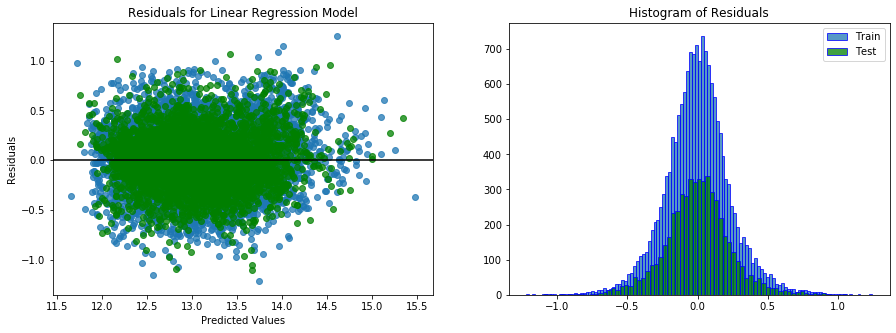

LinearRegression()

In [74]:
predictors = continuous + logs + ohe_cols + Area_cols
ut.sk_linear_regression(df_ohe_d, predictors, outcome, log=True)

In [75]:
model = ut.sm_linear_regression(df_ohe_d, predictors, outcome, log=True)
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.804
Model:                            OLS   Adj. R-squared:                  0.803
Method:                 Least Squares   F-statistic:                     1651.
Date:                Sat, 30 Jan 2021   Prob (F-statistic):               0.00
Time:                        16:25:41   Log-Likelihood:                 618.78
No. Observations:               16195   AIC:                            -1156.
Df Residuals:                   16154   BIC:                            -840.2
Df Model:                          40                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const              -156.8542      5.394    -29.078      0.000    -167.428    -146.281
lat                   1.1310      0.038     29.665      0.000       1.056       1.206
long                 -0.9074      0.042    -21.561      0.000      -0.990      -0.825
sqft_living_log       0.5481      0.009     62.197      0.000       0.531       0.565
sqft_lot_log          0.0563      0.003     18.801      0.000       0.050       0.062
Gra_Fine              0.2354      0.009     27.548      0.000       0.219       0.252
Gra_Good              0.4593      0.011     43.683      0.000       0.439       0.480
Gra_Okay              0.1108      0.007     15.525      0.000       0.097       0.125
Con_Fine              0.1708      0.020      8.627      0.000       0.132       0.210
Con_Good              0.2419      0.021     11.752      0.000       0.202       0.282
Con_Okay              0.1076      0.020      5.471      0.000       0.069       0.146
Bed_MED               0.0272      0.005      5.878      0.000       0.018       0.036
Bed_SM                0.0914      0.008     11.939      0.000       0.076       0.106
Bat_Low              -0.0039      0.007     -0.525      0.599      -0.018       0.011
Bat_Med              -0.0122      0.005     -2.268      0.023      -0.023      -0.002
Bui_BUN               0.0865      0.007     12.301      0.000       0.073       0.100
Bui_HOU               0.0299      0.005      5.470      0.000       0.019       0.041
wat_1.0               0.6785      0.023     29.507      0.000       0.633       0.724
Rec_True              0.0412      0.006      6.905      0.000       0.029       0.053
Are_Bellevue          0.4956      0.013     36.808      0.000       0.469       0.522
Are_Black Diamond     0.4012      0.028     14.191      0.000       0.346       0.457
Are_Bothell          -0.0732      0.025     -2.872      0.004      -0.123      -0.023
Are_Carnation         0.1027      0.025      4.141      0.000       0.054       0.151
Are_Enumclaw          0.3801      0.021     18.402      0.000       0.340       0.421
Are_Fall City         0.4356      0.035     12.455      0.000       0.367       0.504
Are_Federal Way      -0.1294      0.013     -9.833      0.000      -0.155      -0.104
Are_Issaquah          0.4301      0.015     27.835      0.000       0.400       0.460
Are_Kenmore          -0.1266      0.023     -5.456      0.000      -0.172      -0.081
Are_Kirkland          0.1600      0.017      9.439      0.000       0.127       0.193
Are_Maple Valley      0.2386      0.014     16.758      0.000       0.211       0.267
Are_Medina            0.9822      0.040     24.267      0.000       0.903       1.062
Are_Mercer            0.5857      0.019     30.064      0.000       0.548       0.624
Are_N Seattle        -0.0921      0.020     -4.597      0.000      -0.131

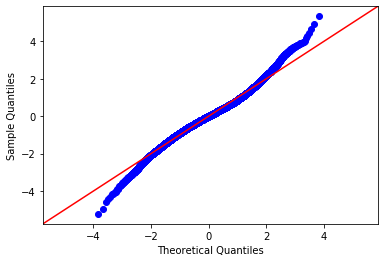

In [76]:
ut.qqplot(model)

In this case, our R2 score has settled around .804, which seems slightly underfit based on the score of our Testing data. In one hot encoding our data, we have gotten further from a normal distribution of residuals, so we have two more steps. First, we're going to standardize our data for comparison purposes and then we are going to see if a polynomial regression will have a better fit than our linear one.

## Model 6: Scalers and Standardization

In order to measure the impact of each variable on the outcome of our price, we need to ensure that we have weighted each variable on a similar scale. To do this, I'm going to use a simple min/max scaler on every variable.

In [77]:
scaler = MinMaxScaler()

In [78]:
preprocessed = df[continuous+logs]
scaled_cols = []

for column in preprocessed.columns.to_list():
    df_ohe_d[f'{column}_sc'] = scaler.fit_transform(df_ohe_d[column].values.reshape(-1, 1))
    scaled_cols.append(f'{column}_sc')

In [79]:
scaled_cols[2:]

['sqft_living_log_sc', 'sqft_lot_log_sc']

Let's have a look and see how this has affected our model, if at all

Training Scores:
R2: 0.8035122140808263
Root Mean Squared Error: 182046.69308410733
Mean Absolute Error: 99354.99706909758
---
Testing Scores:
R2: 0.8040156034772057
Root Mean Squared Error: 185970.52972801635
Mean Absolute Error: 100930.1049062457


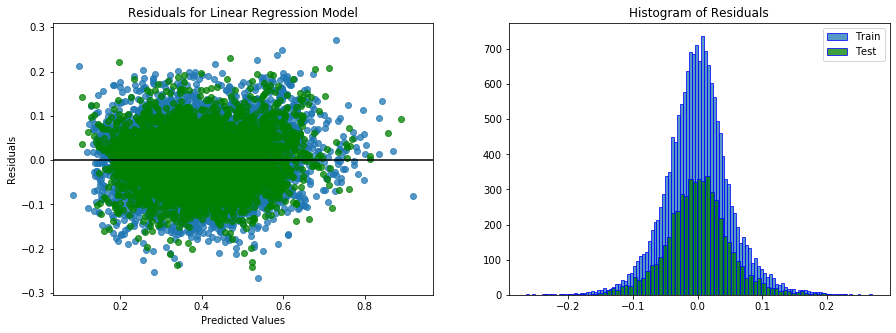

In [80]:
predictors = scaled_cols+Area_cols+ohe_cols
lr = ut.sk_linear_regression(df_ohe_d, predictors, outcome, log=True, scaled=True)

In [81]:
model = ut.sm_linear_regression(df_ohe_d, predictors, outcome, log=True, scaled=True)
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.804
Model:                            OLS   Adj. R-squared:                  0.803
Method:                 Least Squares   F-statistic:                     1651.
Date:                Sat, 30 Jan 2021   Prob (F-statistic):               0.00
Time:                        16:25:42   Log-Likelihood:                 25216.
No. Observations:               16195   AIC:                        -5.035e+04
Df Residuals:                   16154   BIC:                        -5.004e+04
Df Model:                          40                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                 -0.0102      0.006     -1.581      0.114      -0.023       0.002
lat_sc                 0.1540      0.005     29.665      0.000       0.144       0.164
long_sc               -0.2384      0.011    -21.561      0.000      -0.260      -0.217
sqft_living_log_sc     0.4320      0.007     62.197      0.000       0.418       0.446
sqft_lot_log_sc        0.0994      0.005     18.801      0.000       0.089       0.110
Are_Bellevue           0.1085      0.003     36.808      0.000       0.103       0.114
Are_Black Diamond      0.0879      0.006     14.191      0.000       0.076       0.100
Are_Bothell           -0.0160      0.006     -2.872      0.004      -0.027      -0.005
Are_Carnation          0.0225      0.005      4.141      0.000       0.012       0.033
Are_Enumclaw           0.0832      0.005     18.402      0.000       0.074       0.092
Are_Fall City          0.0954      0.008     12.455      0.000       0.080       0.110
Are_Federal Way       -0.0283      0.003     -9.833      0.000      -0.034      -0.023
Are_Issaquah           0.0942      0.003     27.835      0.000       0.088       0.101
Are_Kenmore           -0.0277      0.005     -5.456      0.000      -0.038      -0.018
Are_Kirkland           0.0350      0.004      9.439      0.000       0.028       0.042
Are_Maple Valley       0.0523      0.003     16.758      0.000       0.046       0.058
Are_Medina             0.2151      0.009     24.267      0.000       0.198       0.232
Are_Mercer             0.1283      0.004     30.064      0.000       0.120       0.137
Are_N Seattle         -0.0202      0.004     -4.597      0.000      -0.029      -0.012
Are_North Bend         0.1180      0.006     20.068      0.000       0.106       0.129
Are_Redmond            0.0607      0.004     16.107      0.000       0.053       0.068
Are_Renton             0.0214      0.002      9.449      0.000       0.017       0.026
Are_S Seattle         -0.0176      0.003     -6.620      0.000      -0.023      -0.012
Are_Sammamish          0.0779      0.004     21.333      0.000       0.071       0.085
Are_Seattle            0.0482      0.003     15.928      0.000       0.042       0.054
Are_Snoqualmie         0.0992      0.005     19.975      0.000       0.089       0.109
Are_Vashon            -0.0103      0.006     -1.619      0.106      -0.023       0.002
Gra_Fine               0.0515      0.002     27.548      0.000       0.048       0.055
Gra_Good               0.1006      0.002     43.683      0.000       0.096       0.105
Gra_Okay               0.0243      0.002     15.525      0.000       0.021       0.027
Con_Fine               0.0374      0.004      8.627      0.000       0.029       0.046
Con_Good               0.0530      0.005     11.752      0.000       0.044       0.062
Con_Okay               0.0236      0.0

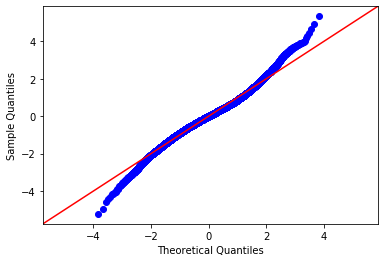

In [82]:
ut.qqplot(model)

Scaling hasn't drastically affected our R2, but it has fixed our multicollinearity issue in a big way, which is fantastic. We still have some abnormality in our residuals. That being said, we can now analyze our coefficients to see which ones are the most impactful. Now that we have sufficiently modeled the data, we can move on to the final 'Interpret' stage of the OSEMN process. 

In [83]:
coefficients = pd.DataFrame.from_dict(dict(zip(predictors, lr.coef_.tolist()[0])),'index')
coefficients.rename(columns= {0:'Coeff'},inplace=True)

In [84]:
coefficients.sort_values('Coeff', ascending=False).head()

,Coeff
sqft_living_log_sc,0.429625
Are_Medina,0.213888
lat_sc,0.153119
wat_1.0,0.147751
Are_Mercer,0.127543


With a little manipulation, we now see the biggest factors affecting sale price are:

    Square Footage of Living Space (0.43)
    Built in Medina (0.214)
    Latitude - How far North the property is (0.153)
    Waterfront View (0.148)
    Built in Mercer (0.128)

We still have some work see if we can increase the model's R2 score of 0.804 (which means we can account for about 80.4% of the data's variance).

## Model 7: Restrict Geography

![medina](Images/medina.jpg)

Now we have a decent idea of the major factors affecting our model. In order to maximize our understanding of the different things that affect sale price, I've restricted our data to the top 1% of properties ordered by price by square foot. You can see them on the map below:

In [85]:
df['price_by_foot'] = df['price']/df['sqft_living']
df_top = df.sort_values(by=['price_by_foot'],ascending=False)
df_top = df_top.iloc[:216]
lat = df_top.lat.mean()
long = df_top.long.mean()

In [86]:
map_2 = folium.Map(location=[lat, long], zoom_start=11)
heat_data = [[row['lat'],row['long']] for index, row in df_top.iterrows()]

HeatMap(heat_data).add_to(map_2)

marker_dict_top = {}

for neighborhood in df_top.Area.unique():
    marker = (df_top.loc[df_top.Area == neighborhood].lat.to_list()[0], df_top.loc[df_top.Area == neighborhood].long.to_list()[0])
    marker_dict_top[neighborhood] = marker

for neighborhood in marker_dict_top.keys():
    folium.Marker([marker_dict_top[neighborhood][0], marker_dict_top[neighborhood][1]], popup=f'{neighborhood}').add_to(map_2)

map_2

As we can see the most expensive properties by living space square foot are mainly centered around the Seattle downtown area, with a primary cluster in Bellevue/Medina. If we remember from our value counts of sale by area, there are only 50 sales for homes in the Medina area. Even so, 13 of those are included in the top 1% of sales ordered by price by square foot, therefore it makes sense that knowing if a property is in Medina, means we know it will most likely have a higher sales price than most properties.

For this iteration of the model, I'm going to restrict our properties to only those west of Sammamish and see how well our model fits.

In [87]:
df_ohe_e = df_ohe_d.loc[df_ohe_d.long <= -121.965]

Training Scores:
R2: 0.8059545741890584
Root Mean Squared Error: 186713.56290913018
Mean Absolute Error: 100932.10962833761
---
Testing Scores:
R2: 0.7987288935869425
Root Mean Squared Error: 178356.66341669005
Mean Absolute Error: 100654.17905234676


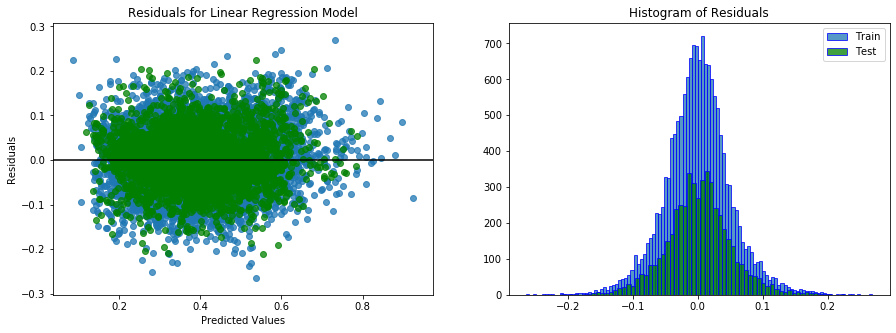

In [88]:
predictors = scaled_cols+Area_cols+ohe_cols
lr = ut.sk_linear_regression(df_ohe_e, predictors, outcome, log=True, scaled=True)

In [89]:
model = ut.sm_linear_regression(df_ohe_e, predictors, outcome, log=True, scaled=True)
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.806
Model:                            OLS   Adj. R-squared:                  0.805
Method:                 Least Squares   F-statistic:                     1740.
Date:                Sat, 30 Jan 2021   Prob (F-statistic):               0.00
Time:                        16:25:43   Log-Likelihood:                 24145.
No. Observations:               15535   AIC:                        -4.821e+04
Df Residuals:                   15497   BIC:                        -4.792e+04
Df Model:                          37                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                 -0.0093      0.007     -1.374      0.169      -0.023       0.004
lat_sc                 0.1527      0.005     29.134      0.000       0.142       0.163
long_sc               -0.2521      0.012    -20.792      0.000      -0.276      -0.228
sqft_living_log_sc     0.4372      0.007     61.347      0.000       0.423       0.451
sqft_lot_log_sc        0.0910      0.006     16.036      0.000       0.080       0.102
Are_Bellevue           0.1073      0.003     35.967      0.000       0.101       0.113
Are_Black Diamond      0.0826      0.007     12.047      0.000       0.069       0.096
Are_Bothell           -0.0151      0.006     -2.700      0.007      -0.026      -0.004
Are_Carnation          0.0126      0.007      1.854      0.064      -0.001       0.026
Are_Enumclaw           0.0811      0.005     16.855      0.000       0.072       0.091
Are_Fall City       9.671e-17    1.4e-17      6.910      0.000    6.93e-17    1.24e-16
Are_Federal Way       -0.0310      0.003    -10.417      0.000      -0.037      -0.025
Are_Issaquah           0.0940      0.003     27.121      0.000       0.087       0.101
Are_Kenmore           -0.0300      0.005     -5.877      0.000      -0.040      -0.020
Are_Kirkland           0.0343      0.004      9.124      0.000       0.027       0.042
Are_Maple Valley       0.0551      0.003     17.318      0.000       0.049       0.061
Are_Medina             0.2114      0.009     24.063      0.000       0.194       0.229
Are_Mercer             0.1298      0.004     30.812      0.000       0.122       0.138
Are_N Seattle         -0.0230      0.004     -5.159      0.000      -0.032      -0.014
Are_North Bend     -1.146e-16   5.87e-18    -19.530      0.000   -1.26e-16   -1.03e-16
Are_Redmond            0.0613      0.004     16.017      0.000       0.054       0.069
Are_Renton             0.0200      0.002      8.710      0.000       0.016       0.025
Are_S Seattle         -0.0207      0.003     -7.558      0.000      -0.026      -0.015
Are_Sammamish          0.0784      0.004     21.036      0.000       0.071       0.086
Are_Seattle            0.0455      0.003     14.633      0.000       0.039       0.052
Are_Snoqualmie     -7.573e-17   4.51e-18    -16.785      0.000   -8.46e-17   -6.69e-17
Are_Vashon            -0.0182      0.006     -2.801      0.005      -0.031      -0.005
Gra_Fine               0.0492      0.002     25.749      0.000       0.045       0.053
Gra_Good               0.0990      0.002     41.985      0.000       0.094       0.104
Gra_Okay               0.0226      0.002     14.136      0.000       0.019       0.026
Con_Fine               0.0458      0.005     10.165      0.000       0.037       0.055
Con_Good               0.0629      0.005     13.464      0.000       0.054       0.072
Con_Okay               0.0324      0.0

Sadly it looks like restricting our georaphy to the Seattle area looks as though it overfits the data and isn't helpful in this initial exploration.

# Conclusion

As we have seen, in our final model, we could account for about 80% of the variance in the housing data. Our mean absolute error for the model is around $100,000, which is not ideal for accurately predicting a sale price. That said, based on this model, we know that the five most influential factors in property sale price are:

    Square Footage of Living Space (0.43)
    Built in Medina (0.214)
    Latitude - How far North the property is (0.153)
    Waterfront View (0.148)
    Built in Mercer (0.128)
    
Therefore, our developers who hired us, should focus on identifying plots to rehab or build new construction in either Medina or Mercer that have a large square footage and a waterfront view. Again, with a quick sanity check, we can tell that these conclusions are very reasonable. Bill Gates' infamous mansion is located in Medina, on the waterfront.

## Areas of Further Study

This model has a lot of room for improvement. Several areas of exploration would be to restrict the geography to a small area of Seattle. One thing we must also account for in the real life version of this exercise, is that while scoring some development space in Medina would be incredibly profitable for a developer, since only 50 homes sold in that township in 2 years, it might not be feasible to focus the company's energy on developing property in that area, as almost all land is probably already developed. A more interesting exercise would be to identify areas of Seattle where housing prices are increasing and possibly predict which neighborhoods will be ideal for development in the future. Granted, with Seattle's history of gentrification, this has numerous political factors to consider as well.